# 0. Introducción y definición de funciones generales


In [282]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability.python.distributions as tfd
import tensorflow_probability.python.layers as tfl
from scipy.stats import poisson

In [517]:
data_path = "C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-truth/JHU/"
cols = ["cases"]
target_cols = ["cases"]
input_width = 1
label_width = 1
# shift = 1
train_data_pcnt = 70
valid_data_pcnt = 20
test_data_pcnt = 10
epochs = 1000
final_model_path = "Models/Final/"
results_path = "Models/Results/"
graphs_path = "Models/Graphs/"
processed_path = "C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/"
display_images = True
save_images = False
period = "weeks"
last_day = "2021-07-31"
first_day = "2020-01-23"
# predictions_date_init = "2021-09-13"
# predictions_date_end = "2021-09-25"
# team_model_name = "UNED-CovidPredPMA"
countries = [
    # 'Austria',
    # 'Belgium',
    # 'Bulgaria',
    # 'Croatia',
    # 'Cyprus',
    # 'Czechia',
    # 'Denmark',
    # 'Estonia',
    # 'Finland',
    'France',
    'Germany',
    # 'Greece',
    # 'Hungary',
    # 'Iceland',
    # 'Ireland',
    'Italy',
    # 'Latvia',
    # 'Liechtenstein',
    # 'Lithuania',
    # 'Luxembourg',
    # 'Malta',
    # 'Netherlands',
    # 'Norway',
    # 'Poland',
    # 'Portugal',
    # 'Romania',
    # 'Slovakia',
    # 'Slovenia',
    'Spain',
    # 'Sweden',
    # 'Switzerland',
    'United Kingdom'
]
country_codes = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Iceland': 'IS',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Liechtenstein': 'LI',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Norway': 'NO',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE',
    'Switzerland': 'CH',
    'United Kingdom': 'GB',
}
quantiles = [
    1.00,
    2.50,
    5.00,
    10.0,
    15.0,
    20.0,
    25.0,
    30.0,
    35.0,
    40.0,
    45.0,
    50.0,
    55.0,
    60.0,
    65.0,
    70.0,
    75.0,
    80.0,
    85.0,
    90.0,
    95.0,
    97.5,
    99.0]
median_quantile_index = 11
quantile_50_low_index = 6
quantile_50_high_index = 16
quantile_95_low_index = 1
quantile_95_high_index = 21
country = 'Spain'

In [284]:
def read_truth_data(filepath, filepath_deaths, truth_last_day):
    df_cases = pd.read_csv(filepath)
    df_deaths = pd.read_csv(filepath_deaths)
    if country == "all":
        df_filtered = df_cases
        df_deaths_filtered = df_deaths
    else:
        df_filtered = df_cases[(df_cases["location_name"] == country)]
        df_deaths_filtered = df_deaths[(df_deaths["location_name"] == country)]

    df_filtered["value"] = df_filtered["value"].where(df_filtered["value"] >= 0, other=-df_filtered["value"], axis=0)
    df_deaths_filtered["value"] = df_deaths_filtered["value"].where(df_deaths_filtered["value"] >= 0,
                                                                    other=-df_deaths_filtered["value"], axis=0)
    df_filtered["date"] = pd.to_datetime(df_filtered["date"])
    df_filtered.set_index(df_filtered["date"], inplace=True)
    df_deaths_filtered["date"] = pd.to_datetime(df_deaths_filtered["date"])
    df_deaths_filtered.set_index(df_deaths_filtered["date"], inplace=True)
    df_filtered.drop("date", axis=1, inplace=True)
    df_filtered.drop("location", axis=1, inplace=True)
    df_filtered.drop("location_name", axis=1, inplace=True)
    df_filtered["cases"] = df_filtered["value"]
    df_filtered.drop(labels="value", axis=1, inplace=True)
    # df_filtered["deaths"] = df_deaths_filtered["value"]
    # df_filtered.replace(to_replace='United Kingdom', value='United_Kingdom', inplace=True)

    # Include data only after 1th case in a country.
    # mask = df_filtered['cases'].cumsum() >= 1

    # Get the date that the epidemic starts in a country.
    # first_day = df_filtered.index[mask][0]  # - pd.to_timedelta(START_DAYS, 'days')
    if first_day is not None:
        df_filtered = df_filtered.truncate(before=first_day)
    if truth_last_day is not None:
        df_filtered = df_filtered.truncate(after=truth_last_day)

    if period == "weeks":
        df_filtered = df_filtered.resample("w-sat", convention="end").sum()

    return df_filtered

In [285]:
def nll(y, distr):
    return -distr.log_prob(y)

In [286]:
def plot_linear_model(model=None, plot_col='cases', plot_model="random", plot_quantile=True,
                      final_image_path=None, x=None, y=None):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    num_days = len(x)

    pred_cases_raw = model(x)
    mean = pred_cases_raw.mean()
    std = pred_cases_raw.stddev()
    # posterior_quantile = np.percentile(mean, quantiles, axis=-1, interpolation="midpoint")
    ax.plot(range(num_days), mean, '--X', color='#ff7f0e', label='Posterior median', lw=3, markersize=6)
    if plot_quantile:
        ax.plot(range(num_days), mean + 2 * std, color='b', label='50% quantile', alpha=.4, lw=3)
        ax.plot(range(num_days), mean - 2 * std, color='b', label='50% quantile', alpha=.4, lw=3)
    ax.plot(range(num_days), y[:num_days], '--o', color='k', markersize=6, label='Observed '+plot_col)

    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(plot_model + " set for " + country + " " + plot_col)
    ax.set_xlabel('Day', fontsize='large')
    ax.set_ylabel(plot_col, fontsize='large')
    fontsize = 'large'
    ax.legend(loc='upper left', fontsize=fontsize)
    ax.axhline(y=0, color='k', linestyle='--')

    plt.tight_layout()
    if save_images:
        plt.savefig(final_image_path + "_predictions.png")
    if display_images:
        plt.show()

    return

In [287]:
def plot_linear_cpd(model=None, num_weeks=1, x=None, y=None):
    y_hat=model.predict(x)
    # y_hat_mean = y_hat.mean()
    y_hat_std = y_hat.std()
    plt.scatter(y_hat, y, alpha=0.3)
    # sort_idx=np.argsort(y_hat,axis=0)
    plt.plot(y_hat, y_hat + 2 * y_hat_std, linestyle='dashed', c="black")
    plt.plot(y_hat, y_hat - 2 * y_hat_std, linestyle='dashed', c="black")
    plt.plot(y_hat, y_hat, c="black")
    plt.title('Observed vs. Predicted for ' + country + " and " + str(num_weeks) + " predicted weeks")
    plt.xlabel('Predicted average')
    plt.ylabel('Observed number')
    plt.show()

    return

In [288]:
def plot_train_history(history, title, final_image_path):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    num_epochs = range(len(loss))

    plt.figure()
    plt.plot(num_epochs, loss, 'b', label='Training loss')
    plt.plot(num_epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    if save_images:
        plt.savefig(final_image_path + "_train_history.png")
    if display_images:
        plt.show()

    return

In [518]:
def create_forecasts_file(values, date_init, date_end, num_weeks, folder_name, team_model_name, quantiles=[2.5, 25, 50, 75, 97.5],
                          plot_col_index=0):
    forecast_filename = processed_path + folder_name + "/" + date_init + "-" + team_model_name + ".csv"
    print(forecast_filename)
    if os.path.exists(forecast_filename):
        append_write = 'a'  # append if already exists
    else:
        append_write = 'w'  # make a new file if not

    with open(forecast_filename, append_write) as file:
        if append_write == "w":
            file.write("scenario_id,forecast_date,target,target_end_date,location,type,quantile,value\n")
        for i in range(len(values)):
            file.write("forecast,")
            file.write(date_init + ",")
            file.write(str(num_weeks) + " wk ahead inc case,")
            file.write(date_end + ",")
            file.write(country_codes[country] + ",")
            if i == 0:
                file.write("point,NA,")
                if values[median_quantile_index] < 0:
                    file.write(str(-values[median_quantile_index]) + "\n")
                else:
                    file.write(str(values[median_quantile_index]) + "\n")
                if len(values) > 1:
                    file.write("forecast,")
                    file.write(date_init + ",")
                    file.write(str(num_weeks) + " wk ahead inc case,")
                    file.write(date_end + ",")
                    file.write(country_codes[country] + ",")
                    file.write("quantile,")
                    file.write(str(quantiles[i] / 100.00) + ",")
                    if values[i] < 0:
                        file.write(str(-values[i]) + "\n")
                    else:
                        file.write(str(values[i]) + "\n")
            else:
                file.write("quantile,")
                file.write(str(quantiles[i] / 100.00) + ",")
                if values[i] < 0:
                    file.write(str(-values[i]) + "\n")
                else:
                    file.write(str(values[i]) + "\n")
    file.close()

    return


# 1. Regresión lineal

In [ ]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-07-31")

In [213]:
image_path = "{0}_{1}_{2}_linear".format(country, target_cols, datetime.datetime.today().strftime("%Y%m%d"))
file_path = "{0}_{1}_linear".format(country, datetime.datetime.today().strftime("%Y%m%d"))
df_train = df[0:int(len(df) * (train_data_pcnt / 100))]
df_valid = df[int(len(df)*(train_data_pcnt/100)):int(len(df)*((train_data_pcnt + valid_data_pcnt)/100))]
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

In [214]:
shift=0  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_1_w = np.array(df_train, dtype=np.float32)
x_train_1_w = data_train_1_w[:-label_width-shift]
y_train_1_w = np.squeeze(data_train_1_w[input_width+shift:])
data_valid_1_w = np.array(df_valid, dtype=np.float32)
x_valid_1_w = data_valid_1_w[:-label_width-shift]
y_valid_1_w = np.squeeze(data_valid_1_w[input_width+shift:])
data_test_1_w = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test_1_w[:-label_width-shift]
y_test_1_w = np.squeeze(data_test_1_w[input_width+shift:])

In [215]:
model_lr_1_w = tf.keras.Sequential([
        tf.keras.layers.Dense(2),
        tfl.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :1],
                                                    scale=1e-3 + tf.math.softplus(0.05 * t[:, 1:]))),
    ])
model_lr_1_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
result_lr_1_w = model_lr_1_w.fit(x_train_1_w, y_train_1_w, epochs=epochs, validation_data=(x_valid_1_w, y_valid_1_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 124ms/step - loss: 11684621737525248.0000 - val_loss: 4528120132534272.0000
Epoch 2/1000
2/2 [==============================] - 0s 22ms/step - loss: 11424114791153664.0000 - val_loss: 4430966630121472.0000
Epoch 3/1000
2/2 [==============================] - 0s 26ms/step - loss: 11208657756749824.0000 - val_loss: 4334366373183488.0000
Epoch 4/1000
2/2 [==============================] - 0s 29ms/step - loss: 11006213399511040.0000 - val_loss: 4240444028354560.0000
Epoch 5/1000
2/2 [==============================] - 0s 22ms/step - loss: 10737650168233984.0000 - val_loss: 4150288906715136.0000
Epoch 6/1000
2/2 [==============================] - 0s 26ms/step - loss: 10530552213929984.0000 - val_loss: 4059749653938176.0000

In [266]:
model_lr_1_w.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_18 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


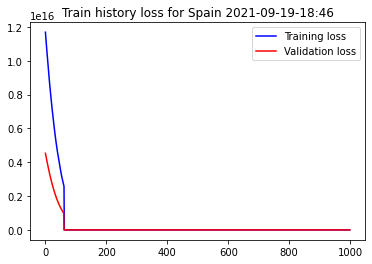

1/1 [==============================] - 0s 14ms/step - loss: 15651.3428
Linear Regression NLL on training 1 week:  40992.2890625
Linear Regression NLL on validation 1 week:  7722.47216796875
Linear Regression NLL on test 1 week:  15651.3427734375


In [216]:
plot_train_history(result_lr_1_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path)

train_performance_1_w = model_lr_1_w.evaluate(x_train_1_w, y_train_1_w, verbose=1)
val_performance_1_w = model_lr_1_w.evaluate(x_valid_1_w, y_valid_1_w, verbose=1)
test_performance_1_w = model_lr_1_w.evaluate(x_test_1_w, y_test_1_w, verbose=1)
print("Linear Regression NLL on training 1 week: ", train_performance_1_w)
print("Linear Regression NLL on validation 1 week: ", val_performance_1_w)
print("Linear Regression NLL on test 1 week: ", test_performance_1_w)

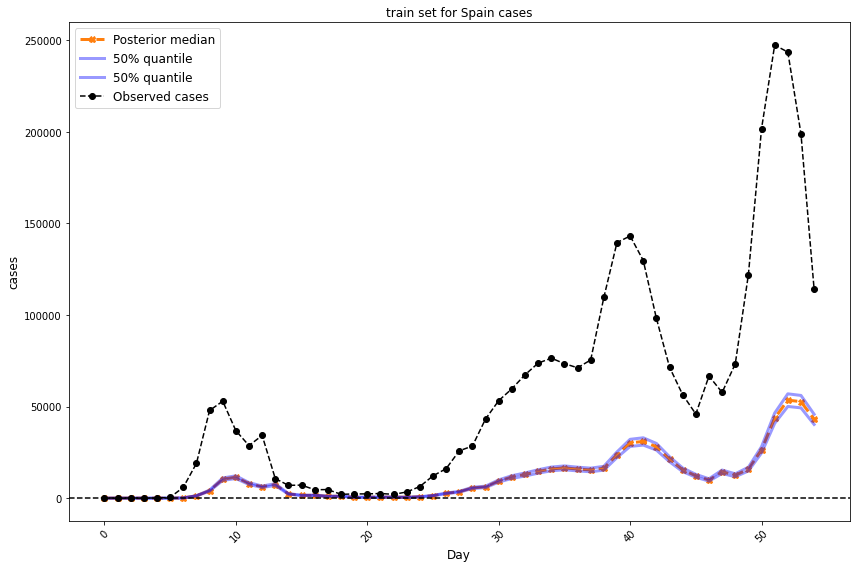

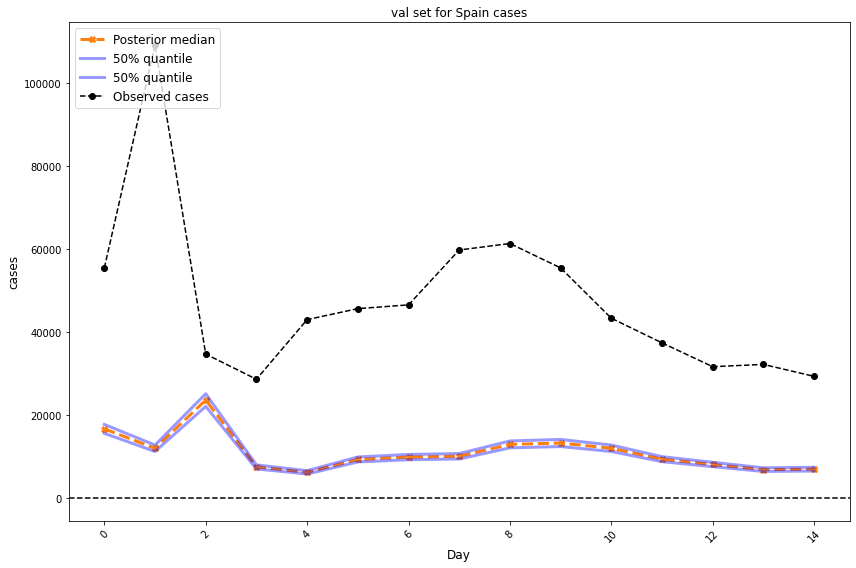

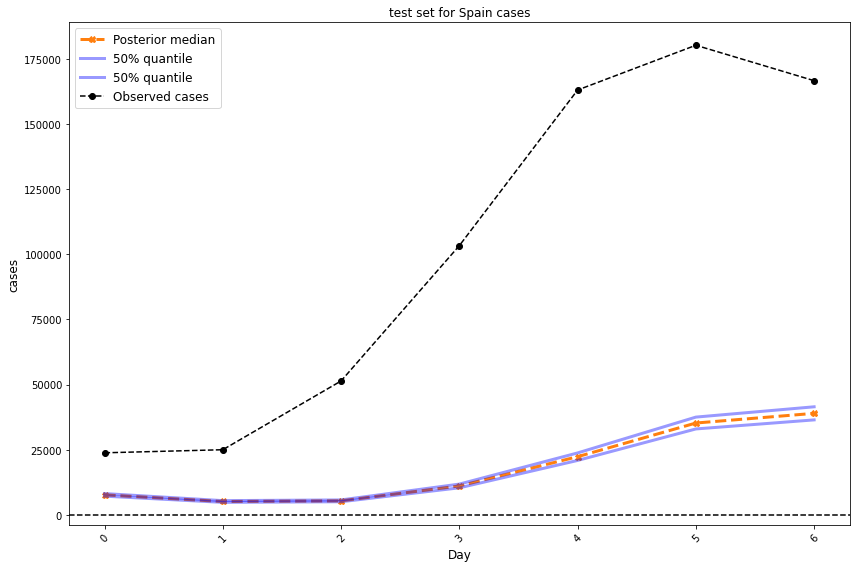

In [217]:
plot_linear_model(model_lr_1_w, plot_model="train", plot_col="cases", x=x_train_1_w, y=y_train_1_w,
                  final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_1_w, plot_model="val", plot_col="cases", x=x_valid_1_w, y=y_valid_1_w,
                  final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_1_w, plot_model="test", plot_col="cases", x=x_test_1_w, y=y_test_1_w,
                  final_image_path=graphs_path + image_path)

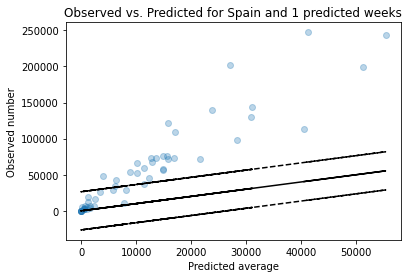

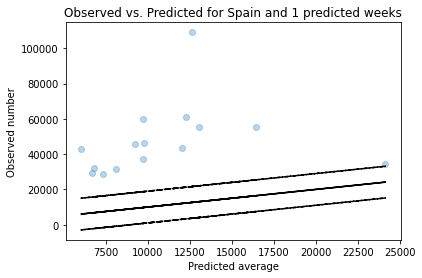

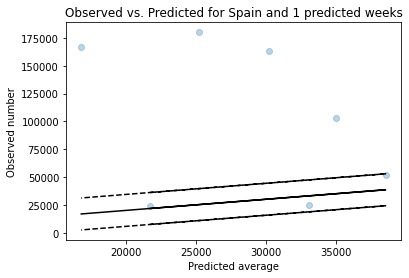

In [265]:
plot_linear_cpd(model_lr_1_w, 1, x_train_1_w, y_train_1_w)
plot_linear_cpd(model_lr_1_w, 1, x_valid_1_w, y_valid_1_w)
plot_linear_cpd(model_lr_1_w, 1, x_test_1_w, y_test_1_w)

In [218]:
shift=1  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_2_w = np.array(df_train, dtype=np.float32)
x_train_2_w = data_train_2_w[:-label_width-shift]
y_train_2_w = np.squeeze(data_train_2_w[input_width+shift:])
data_valid_2_w = np.array(df_valid, dtype=np.float32)
x_valid_2_w = data_valid_2_w[:-label_width-shift]
y_valid_2_w = np.squeeze(data_valid_2_w[input_width+shift:])
data_test_2_w = np.array(df_test, dtype=np.float32)
x_test_2_w = data_test_2_w[:-label_width-shift]
y_test_2_w = np.squeeze(data_test_2_w[input_width+shift:])

In [219]:
model_lr_2_w = tf.keras.Sequential([
        tf.keras.layers.Dense(2),
        tfl.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :1],
                                                    scale=1e-3 + tf.math.softplus(0.05 * t[:, 1:]))),
    ])
model_lr_2_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
result_lr_2_w = model_lr_2_w.fit(x_train_2_w, y_train_2_w, epochs=epochs, validation_data=(x_valid_2_w, y_valid_2_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 238ms/step - loss: 62249.3320 - val_loss: 590.1960
Epoch 2/1000
2/2 [==============================] - 0s 18ms/step - loss: 60650.9570 - val_loss: 565.4995
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 59274.4688 - val_loss: 542.4775
Epoch 4/1000
2/2 [==============================] - 0s 17ms/step - loss: 57510.9805 - val_loss: 521.5369
Epoch 5/1000
2/2 [==============================] - 0s 17ms/step - loss: 56284.0898 - val_loss: 500.9003
Epoch 6/1000
2/2 [==============================] - 0s 19ms/step - loss: 55579.1758 - val_loss: 479.8953
Epoch 7/1000
2/2 [==============================] - 0s 18ms/step - loss: 54358.8398 - val_loss: 460.0906

In [267]:
model_lr_2_w.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_19 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


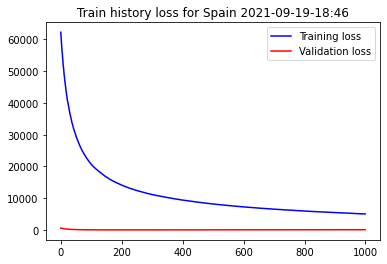

1/1 [==============================] - 0s 14ms/step - loss: 43.8939
Linear Regression NLL on training 2 weeks:  5030.89404296875
Linear Regression NLL on validation 2 weeks:  76.71846771240234
Linear Regression NLL on test 2 weeks:  43.893863677978516


In [220]:
plot_train_history(result_lr_2_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path)

train_performance_2_w = model_lr_2_w.evaluate(x_train_2_w, y_train_2_w, verbose=1)
val_performance_2_w = model_lr_2_w.evaluate(x_valid_2_w, y_valid_2_w, verbose=1)
test_performance_2_w = model_lr_2_w.evaluate(x_test_2_w, y_test_2_w, verbose=1)
print("Linear Regression NLL on training 2 weeks: ", train_performance_2_w)
print("Linear Regression NLL on validation 2 weeks: ", val_performance_2_w)
print("Linear Regression NLL on test 2 weeks: ", test_performance_2_w)

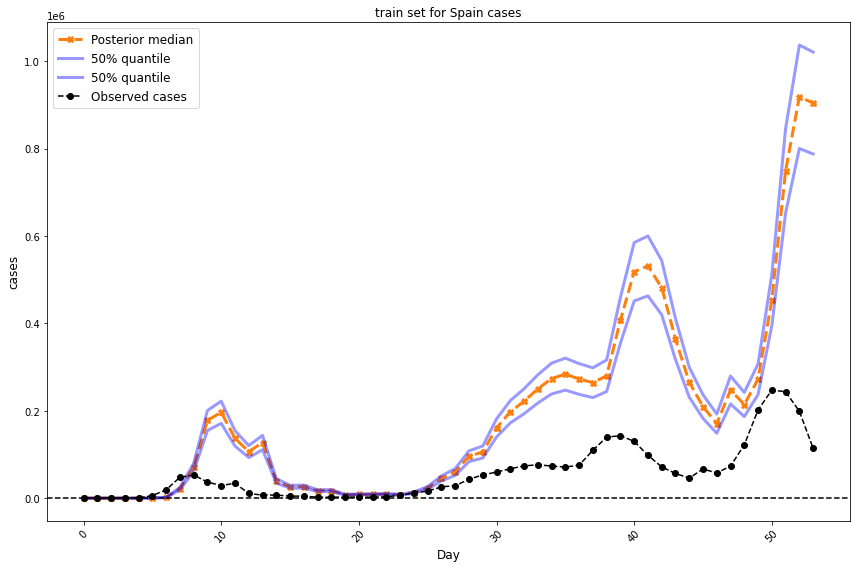

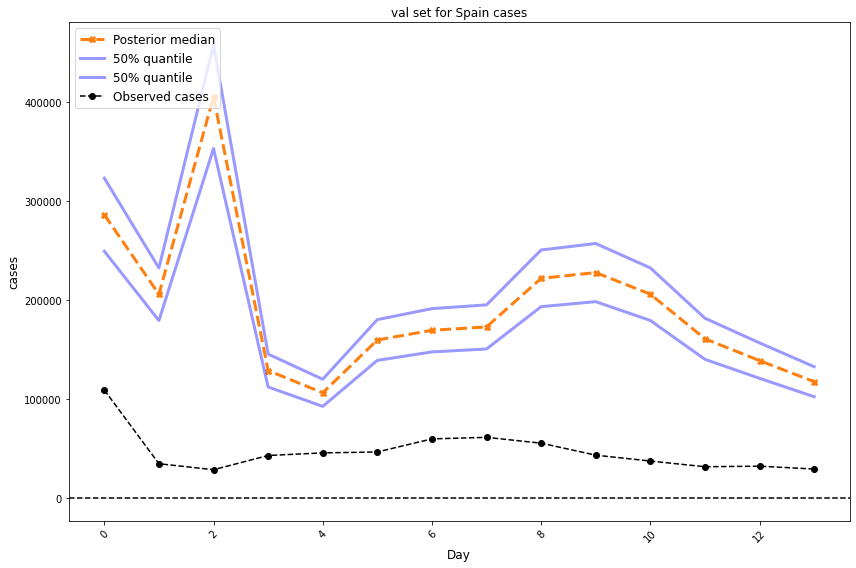

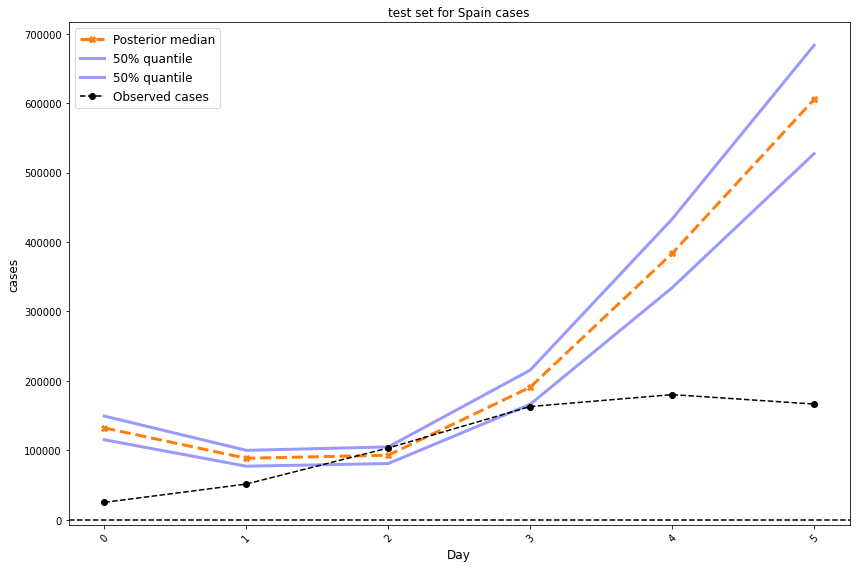

In [221]:
plot_linear_model(model_lr_2_w, plot_model="train", plot_col="cases", x=x_train_2_w, y=y_train_2_w,
                  final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_2_w, plot_model="val", plot_col="cases", x=x_valid_2_w, y=y_valid_2_w,
              final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_2_w, plot_model="test", plot_col="cases", x=x_test_2_w, y=y_test_2_w,
              final_image_path=graphs_path + image_path)

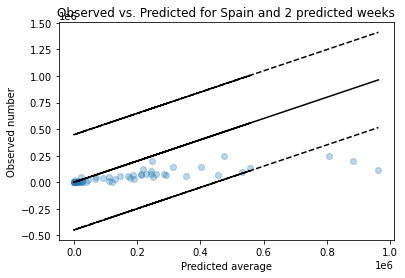

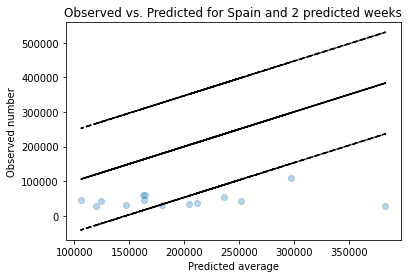

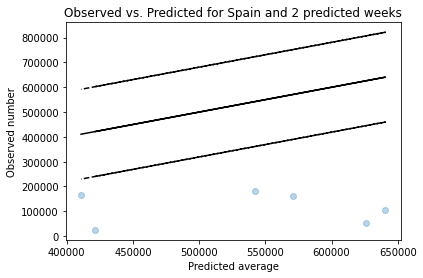

In [268]:
plot_linear_cpd(model_lr_2_w, 2, x_train_2_w, y_train_2_w)
plot_linear_cpd(model_lr_2_w, 2, x_valid_2_w, y_valid_2_w)
plot_linear_cpd(model_lr_2_w, 2, x_test_2_w, y_test_2_w)

In [222]:
shift=2  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_3_w = np.array(df_train, dtype=np.float32)
x_train_3_w = data_train_3_w[:-label_width-shift]
y_train_3_w = np.squeeze(data_train_3_w[input_width+shift:])
data_valid_3_w = np.array(df_valid, dtype=np.float32)
x_valid_3_w = data_valid_3_w[:-label_width-shift]
y_valid_3_w = np.squeeze(data_valid_3_w[input_width+shift:])
data_test_3_w = np.array(df_test, dtype=np.float32)
x_test_3_w = data_test_3_w[:-label_width-shift]
y_test_3_w = np.squeeze(data_test_3_w[input_width+shift:])

In [223]:
model_lr_3_w = tf.keras.Sequential([
        tf.keras.layers.Dense(2),
        tfl.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :1],
                                                    scale=1e-3 + tf.math.softplus(0.05 * t[:, 1:]))),
    ])
model_lr_3_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
result_lr_3_w = model_lr_3_w.fit(x_train_3_w, y_train_3_w, epochs=epochs, validation_data=(x_valid_3_w, y_valid_3_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 129ms/step - loss: 1370193.2500 - val_loss: 438.3403
Epoch 2/1000
2/2 [==============================] - 0s 19ms/step - loss: 1359418.2500 - val_loss: 416.3796
Epoch 3/1000
2/2 [==============================] - 0s 19ms/step - loss: 1340466.1250 - val_loss: 396.5928
Epoch 4/1000
2/2 [==============================] - 0s 19ms/step - loss: 1323852.6250 - val_loss: 378.1126
Epoch 5/1000
2/2 [==============================] - 0s 19ms/step - loss: 1301047.1250 - val_loss: 362.0165
Epoch 6/1000
2/2 [==============================] - 0s 24ms/step - loss: 1287164.6250 - val_loss: 345.9285
Epoch 7/1000
2/2 [==============================] - 0s 19ms/step - loss: 1272137.5000 - val_loss: 330.4907

In [269]:
model_lr_3_w.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_20 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


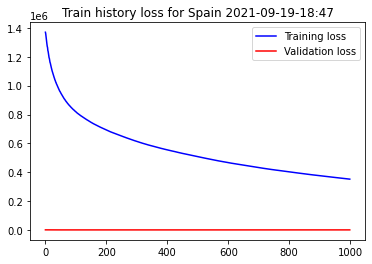

1/1 [==============================] - 0s 16ms/step - loss: 77.2962
Linear Regression NLL on training 3 weeks:  351837.78125
Linear Regression NLL on validation 3 weeks:  203.37425231933594
Linear Regression NLL on test 3 weeks:  77.29615783691406


In [224]:
plot_train_history(result_lr_3_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path)

train_performance_3_w = model_lr_3_w.evaluate(x_train_3_w, y_train_3_w, verbose=1)
val_performance_3_w = model_lr_3_w.evaluate(x_valid_3_w, y_valid_3_w, verbose=1)
test_performance_3_w = model_lr_3_w.evaluate(x_test_3_w, y_test_3_w, verbose=1)
print("Linear Regression NLL on training 3 weeks: ", train_performance_3_w)
print("Linear Regression NLL on validation 3 weeks: ", val_performance_3_w)
print("Linear Regression NLL on test 3 weeks: ", test_performance_3_w)

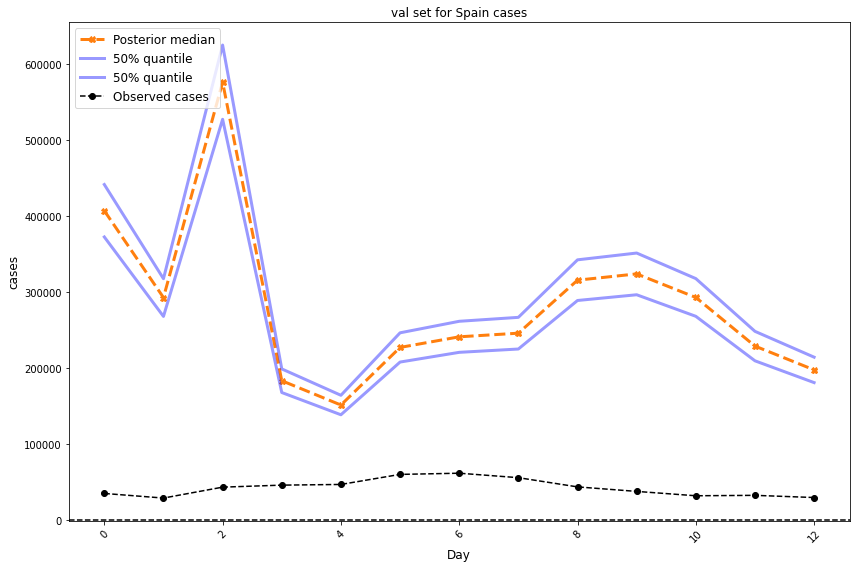

In [225]:
plot_linear_model(model_lr_3_w, plot_model="train", plot_col="cases", x=x_train_3_w, y=y_train_3_w,
                  final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_3_w, plot_model="val", plot_col="cases", x=x_valid_3_w, y=y_valid_3_w,
              final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_3_w, plot_model="test", plot_col="cases", x=x_test_3_w, y=y_test_3_w,
              final_image_path=graphs_path + image_path)

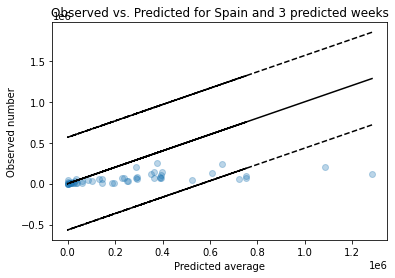

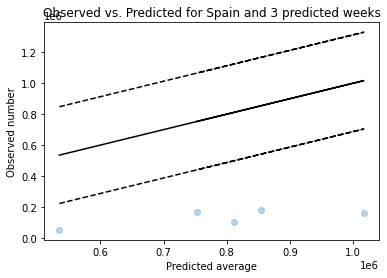

In [270]:
plot_linear_cpd(model_lr_3_w, 3, x_train_3_w, y_train_3_w)
plot_linear_cpd(model_lr_3_w, 3, x_valid_3_w, y_valid_3_w)
plot_linear_cpd(model_lr_3_w, 3, x_test_3_w, y_test_3_w)

In [226]:
shift=3  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_4_w = np.array(df_train, dtype=np.float32)
x_train_4_w = data_train_4_w[:-label_width-shift]
y_train_4_w = np.squeeze(data_train_4_w[input_width+shift:])
data_valid_4_w = np.array(df_valid, dtype=np.float32)
x_valid_4_w = data_valid_4_w[:-label_width-shift]
y_valid_4_w = np.squeeze(data_valid_4_w[input_width+shift:])
data_test_4_w = np.array(df_test, dtype=np.float32)
x_test_4_w = data_test_4_w[:-label_width-shift]
y_test_4_w = np.squeeze(data_test_4_w[input_width+shift:])

In [227]:
model_lr_4_w = tf.keras.Sequential([
        tf.keras.layers.Dense(2),
        tfl.DistributionLambda(lambda t: tfd.Normal(loc=t[:, :1],
                                                    scale=1e-3 + tf.math.softplus(0.05 * t[:, 1:]))),
    ])
model_lr_4_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
result_lr_4_w = model_lr_4_w.fit(x_train_4_w, y_train_4_w, epochs=epochs, validation_data=(x_valid_4_w, y_valid_4_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 176ms/step - loss: 4348611437527040.0000 - val_loss: 1330352295510016.0000
Epoch 2/1000
2/2 [==============================] - 0s 21ms/step - loss: 4253944721178624.0000 - val_loss: 1276308185153536.0000
Epoch 3/1000
2/2 [==============================] - 0s 21ms/step - loss: 4151179843993600.0000 - val_loss: 1224352905297920.0000
Epoch 4/1000
2/2 [==============================] - 0s 26ms/step - loss: 4074405961400320.0000 - val_loss: 1173721683329024.0000
Epoch 5/1000
2/2 [==============================] - 0s 22ms/step - loss: 3979682873606144.0000 - val_loss: 1125040577839104.0000
Epoch 6/1000
2/2 [==============================] - 0s 21ms/step - loss: 3895514936377344.0000 - val_loss: 1077553271930880.0000
Epoc

In [271]:
model_lr_4_w.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_21 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


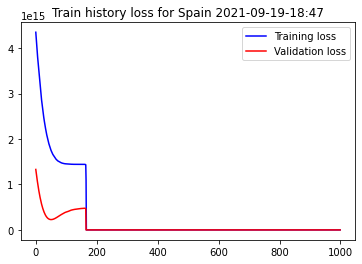

1/1 [==============================] - 0s 24ms/step - loss: 121619.2031
Linear Regression NLL on training 4 weeks:  35000392.0
Linear Regression NLL on validation 4 weeks:  1563.6810302734375
Linear Regression NLL on test 4 weeks:  121619.203125


In [228]:
plot_train_history(result_lr_4_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path)

train_performance_4_w = model_lr_4_w.evaluate(x_train_4_w, y_train_4_w, verbose=1)
val_performance_4_w = model_lr_4_w.evaluate(x_valid_4_w, y_valid_4_w, verbose=1)
test_performance_4_w = model_lr_4_w.evaluate(x_test_4_w, y_test_4_w, verbose=1)
print("Linear Regression NLL on training 4 weeks: ", train_performance_4_w)
print("Linear Regression NLL on validation 4 weeks: ", val_performance_4_w)
print("Linear Regression NLL on test 4 weeks: ", test_performance_4_w)

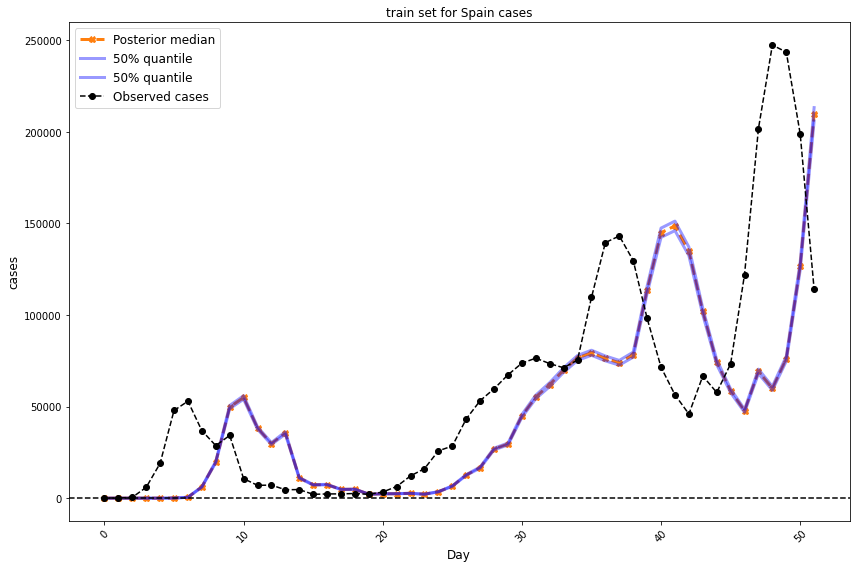

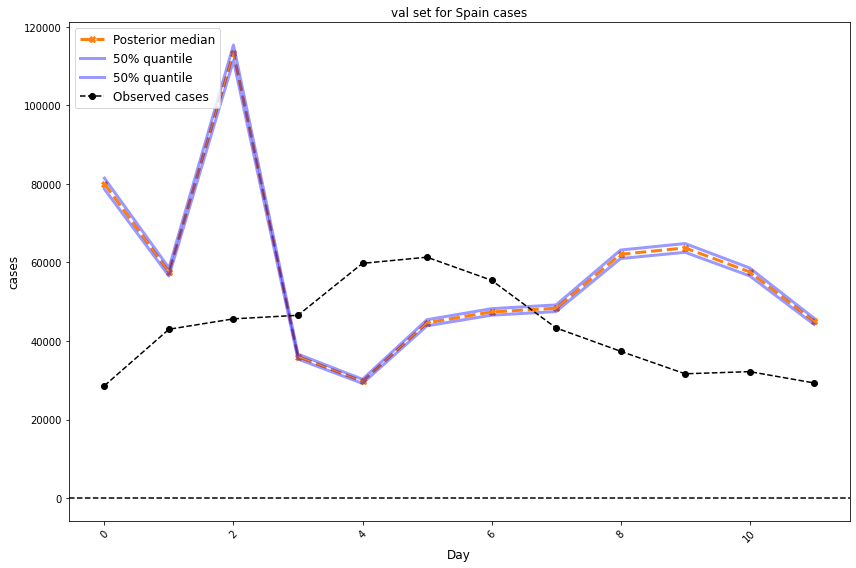

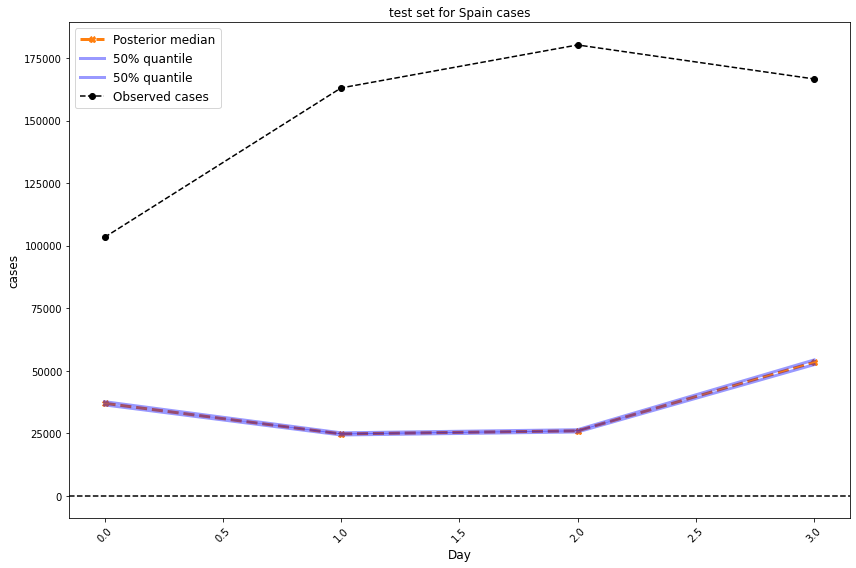

In [229]:
plot_linear_model(model_lr_4_w, plot_model="train", plot_col="cases", x=x_train_4_w, y=y_train_4_w,
                  final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_4_w, plot_model="val", plot_col="cases", x=x_valid_4_w, y=y_valid_4_w,
              final_image_path=graphs_path + image_path)
plot_linear_model(model_lr_4_w, plot_model="test", plot_col="cases", x=x_test_4_w, y=y_test_4_w,
              final_image_path=graphs_path + image_path)

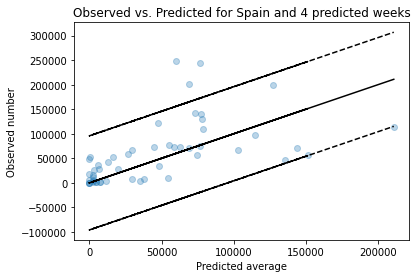

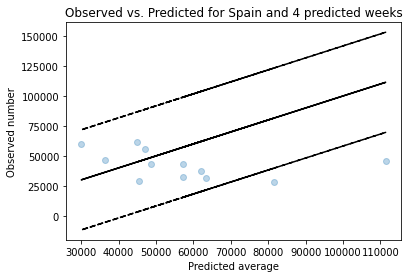

In [272]:
plot_linear_cpd(model_lr_4_w, 4, x_train_4_w, y_train_4_w)
plot_linear_cpd(model_lr_4_w, 4, x_valid_4_w, y_valid_4_w)
plot_linear_cpd(model_lr_4_w, 4, x_test_4_w, y_test_4_w)

In [230]:
print("SUMMARY:\n")
print("Linear Regression NLL on test 1 week: ", test_performance_1_w)
print("Linear Regression NLL on test 2 weeks: ", test_performance_2_w)
print("Linear Regression NLL on test 3 weeks: ", test_performance_3_w)
print("Linear Regression NLL on test 4 weeks: ", test_performance_4_w)

SUMMARY:

Linear Regression NLL on test 1 week:  15651.3427734375
Linear Regression NLL on test 2 weeks:  43.893863677978516
Linear Regression NLL on test 3 weeks:  77.29615783691406
Linear Regression NLL on test 4 weeks:  121619.203125


## Predicción y generación de ficheros

In [ ]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_lr_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_lr_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_lr_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_lr_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")

In [236]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-02", date_end="2021-08-07",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-02", date_end="2021-08-14",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-02", date_end="2021-08-21",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-02", date_end="2021-08-28",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")

In [237]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-08-07")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [238]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]

In [239]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_lr_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_lr_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_lr_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_lr_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")

In [240]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-09", date_end="2021-08-14",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-09", date_end="2021-08-21",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-09", date_end="2021-08-28",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-09", date_end="2021-09-04",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")

In [241]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv",
                     data_path + "truth_JHU-Incident Deaths.csv", "2021-08-14")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [242]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]


In [243]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_lr_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_lr_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_lr_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_lr_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")

In [244]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-16", date_end="2021-08-21",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-16", date_end="2021-08-28",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-16", date_end="2021-09-04",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-16", date_end="2021-09-11",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")

In [245]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-08-21")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [246]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]

In [247]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_lr_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_lr_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_lr_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_lr_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")


In [248]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-23", date_end="2021-08-28",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-23", date_end="2021-09-04",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-23", date_end="2021-09-11",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-23", date_end="2021-09-18",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")

In [249]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-08-28")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [250]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]


In [251]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_lr_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_lr_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_lr_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_lr_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")


In [252]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-30", date_end="2021-09-04",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-30", date_end="2021-09-11",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-30", date_end="2021-09-18",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-30", date_end="2021-09-25",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA",
                      team_model_name="UNED-CovidPredPMA")

# 2. Distribución de Poisson


In [478]:
# processed_path_poisson = "C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA/"
# team_model_name_poisson = "UNED-CovidPredPMA_Poisson"
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-07-31")

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [293]:
image_path_poisson = "{0}_{1}_{2}_poisson".format(country, target_cols, datetime.datetime.today().strftime("%Y%m%d"))
file_path_poisson = "{0}_{1}_poisson".format(country, datetime.datetime.today().strftime("%Y%m%d"))
df_train = df[0:int(len(df) * (train_data_pcnt / 100))]
df_valid = df[int(len(df)*(train_data_pcnt/100)):int(len(df)*((train_data_pcnt + valid_data_pcnt)/100))]
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

In [414]:
shift=0  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_1_w = np.array(df_train, dtype=np.float32)
x_train_1_w = data_train_1_w[:-label_width-shift]
y_train_1_w = np.squeeze(data_train_1_w[input_width+shift:])
data_valid_1_w = np.array(df_valid, dtype=np.float32)
x_valid_1_w = data_valid_1_w[:-label_width-shift]
y_valid_1_w = np.squeeze(data_valid_1_w[input_width+shift:])
data_test_1_w = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test_1_w[:-label_width-shift]
y_test_1_w = np.squeeze(data_test_1_w[input_width+shift:])

In [419]:
inputs = tf.keras.layers.Input(shape=(x_train_1_w.shape[1],))
hidden = tf.keras.layers.Dense(3, activation="relu")(inputs)
hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
# hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
rate = tf.keras.layers.Dense(1, activation=tf.math.softplus)(hidden)
p_y = tfl.DistributionLambda(tfd.Poisson)(rate)
model_p_1_w = tf.keras.models.Model(inputs=inputs, outputs=p_y)

model_p_1_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
model_p_1_w.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_151 (Dense)            (None, 3)                 6         
_________________________________________________________________
dense_152 (Dense)            (None, 10)                40        
_________________________________________________________________
dense_153 (Dense)            (None, 3)                 33        
_________________________________________________________________
dense_154 (Dense)            (None, 1)                 4         
_________________________________________________________________
distribution_lambda_57 (Dist multiple                  0         
Total params: 83
Trainable params: 83
Non-trainable params: 0
______________________________________________________________

In [420]:
result_p_1_w = model_p_1_w.fit(x_train_1_w, y_train_1_w, epochs=epochs, validation_data=(x_valid_1_w, y_valid_1_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 159ms/step - loss: 266693.3438 - val_loss: 186730.0625
Epoch 2/1000
2/2 [==============================] - 0s 18ms/step - loss: 217084.5938 - val_loss: 162158.4688
Epoch 3/1000
2/2 [==============================] - 0s 16ms/step - loss: 188649.0156 - val_loss: 145338.2656
Epoch 4/1000
2/2 [==============================] - 0s 16ms/step - loss: 170660.5781 - val_loss: 132166.9375
Epoch 5/1000
2/2 [==============================] - 0s 16ms/step - loss: 156529.2500 - val_loss: 121298.2109
Epoch 6/1000
2/2 [==============================] - 0s 12ms/step - loss: 143902.1250 - val_loss: 112087.5469
Epoch 7/1000
2/2 [==============================] - 0s 16ms/step - loss: 132896.5156 - val_loss: 104075.0234

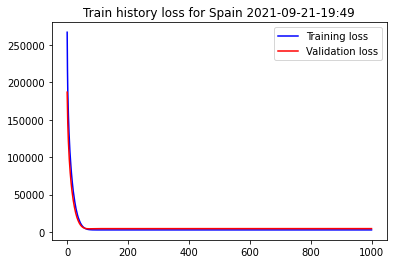

1/1 [==============================] - 0s 16ms/step - loss: 6321.5225
Poisson Distribution NLL on training set, 1 week forecast:  2865.185791015625
Poisson Distribution NLL on validation set,  1 week forecast:  4619.95458984375
Poisson Distribution NLL on test set, 1 week forecast:  6321.5224609375


In [421]:
plot_train_history(result_p_1_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path_poisson)

train_performance_1_w = model_p_1_w.evaluate(x_train_1_w, y_train_1_w, verbose=1)
val_performance_1_w = model_p_1_w.evaluate(x_valid_1_w, y_valid_1_w, verbose=1)
test_performance_1_w = model_p_1_w.evaluate(x_test_1_w, y_test_1_w, verbose=1)
print("Poisson Distribution NLL on training set, 1 week forecast: ", train_performance_1_w)
print("Poisson Distribution NLL on validation set,  1 week forecast: ", val_performance_1_w)
print("Poisson Distribution NLL on test set, 1 week forecast: ", test_performance_1_w)

In [422]:
def plot_poisson_model(model=None, plot_col='cases', plot_model="random", plot_quantile=True, final_image_path=None,
                       x=None, y=None):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    num_days = len(x)

    pred = model.predict(x).flatten()
    print(pred)
    print(pred.shape)
    mean = pred.mean()
    # std = pred.stddev()
    lower=poisson.ppf(0.025, pred)
    upper=poisson.ppf(0.975, pred)
    print(lower)
    print(upper)
    # posterior_quantile = np.percentile(mean, quantiles, axis=-1, interpolation="midpoint")
    ax.plot(range(num_days), pred, '--X', color='#ff7f0e', label='Posterior median', lw=3, markersize=6)
    if plot_quantile:
        ax.plot(range(num_days), upper, color='b', label='95% quantile', alpha=.4, lw=3)
        ax.plot(range(num_days), lower, color='b', label='95% quantile', alpha=.4, lw=3)
    ax.plot(range(num_days), y[:num_days], '--o', color='k', markersize=6, label='Observed '+plot_col)

    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(plot_model + " set for " + country + " " + plot_col)
    ax.set_xlabel('Day', fontsize='large')
    ax.set_ylabel(plot_col, fontsize='large')
    fontsize = 'large'
    ax.legend(loc='upper left', fontsize=fontsize)
    ax.axhline(y=0, color='k', linestyle='--')

    plt.tight_layout()
    if save_images:
        plt.savefig(final_image_path + "_predictions.png")
    if display_images:
        plt.show()

    return

In [423]:
def plot_poisson_cpd(model=None, num_weeks=1, x=None, y=None):
    y_hat=model.predict(x)
    lower=poisson.ppf(0.025, y_hat)
    upper=poisson.ppf(0.975, y_hat)
    plt.scatter(y_hat, y, alpha=0.3)
    print(y_hat, y)
    # sort_idx=np.argsort(y_hat,axis=0)
    plt.plot(y_hat, upper, linestyle='dashed', c="black")
    plt.plot(y_hat, lower, linestyle='dashed', c="black")
    plt.plot(y_hat, y_hat, c="black")
    plt.title('Observed vs. Predicted for ' + country + " and " + str(num_weeks) + " predicted weeks")
    plt.xlabel('Predicted average')
    plt.ylabel('Observed number')
    plt.show()

    return

[1.40000e+01 1.80000e+01 1.10000e+01 1.20000e+01 1.80000e+01 6.00000e+01
 5.09000e+02 6.26700e+03 1.95990e+04 5.00560e+04 5.52650e+04 3.86250e+04
 3.01920e+04 3.61990e+04 1.11860e+04 7.28200e+03 7.40200e+03 4.83000e+03
 4.95500e+03 2.24800e+03 2.41600e+03 2.54700e+03 2.58500e+03 2.17600e+03
 3.48000e+03 6.64800e+03 1.25520e+04 1.67800e+04 2.68660e+04 2.96490e+04
 4.48720e+04 5.58130e+04 6.27020e+04 6.99280e+04 7.66810e+04 7.99500e+04
 7.64760e+04 7.40580e+04 7.92560e+04 1.13850e+05 1.45700e+05 1.49246e+05
 1.35711e+05 1.02191e+05 7.47480e+04 5.87700e+04 4.77510e+04 6.95790e+04
 6.01880e+04 7.68300e+04 1.27420e+05 2.10539e+05 2.57575e+05 2.53559e+05
 2.07539e+05]
(55,)
[7.00000e+00 1.00000e+01 5.00000e+00 6.00000e+00 1.00000e+01 4.50000e+01
 4.65000e+02 6.11200e+03 1.93250e+04 4.96180e+04 5.48050e+04 3.82400e+04
 2.98520e+04 3.58270e+04 1.09790e+04 7.11500e+03 7.23400e+03 4.69400e+03
 4.81800e+03 2.15600e+03 2.32000e+03 2.44900e+03 2.48600e+03 2.08500e+03
 3.36500e+03 6.48900e+03 1.2333

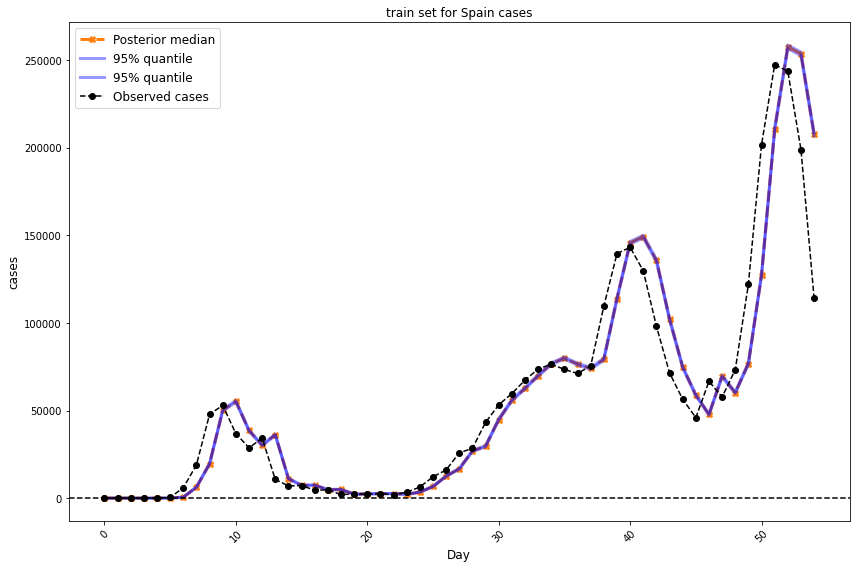

[ 80841.  57643. 114219.  36550.  29856.  45166.  47571.  48394.  62485.
  63521.  58187.  44832.  38931.  32738.  33736.]
(15,)
[ 80284.  57173. 113557.  36176.  29518.  44750.  47144.  47963.  61996.
  63027.  57715.  44417.  38545.  32384.  33376.]
[ 81399.  58114. 114882.  36925.  30195.  45583.  47999.  48826.  62975.
  64015.  58660.  45247.  39318.  33093.  34096.]


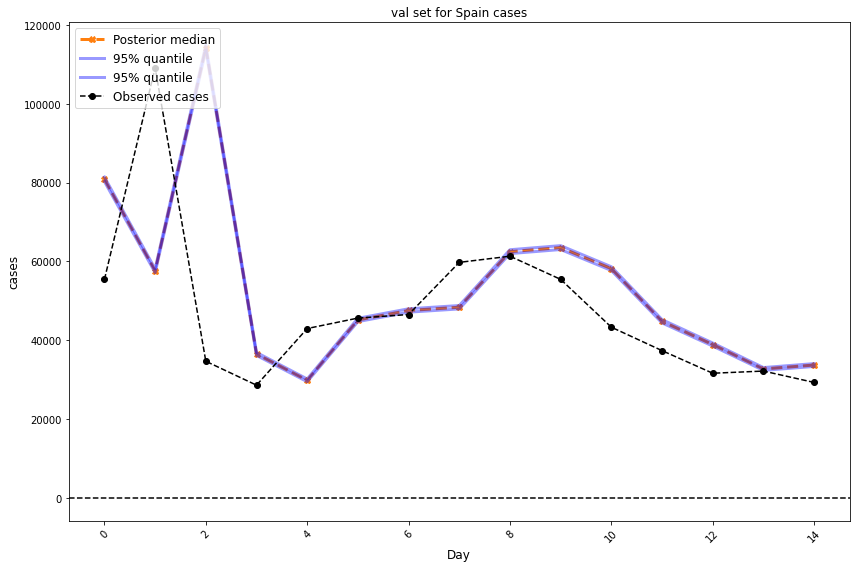

[ 37002.  24856.  26143.  53729. 107682. 170396. 188834.]
(7,)
[ 36625.  24547.  25827.  53275. 107039. 169587. 187983.]
[ 37379.  25165.  26460.  54184. 108326. 171206. 189686.]


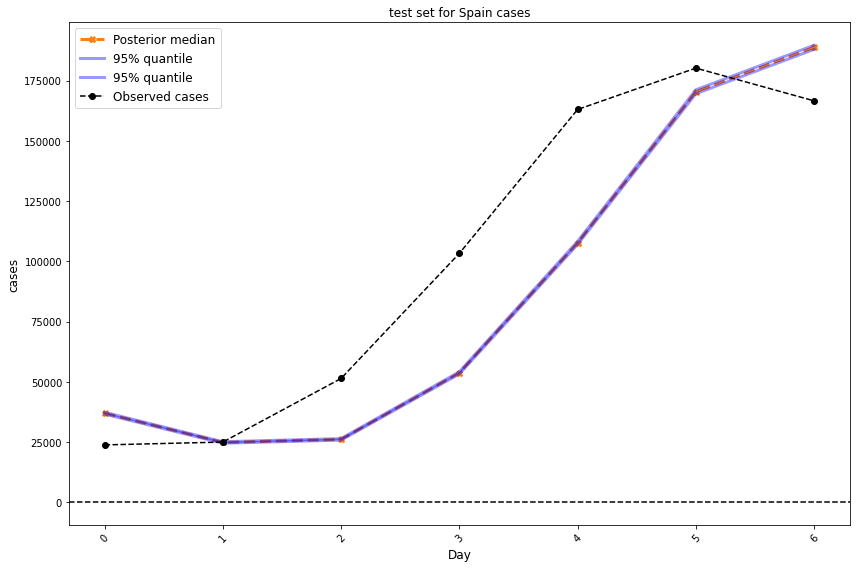

In [424]:
plot_poisson_model(model_p_1_w, plot_model="train", plot_col="cases", x=x_train_1_w, y=y_train_1_w,
                  final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_1_w, plot_model="val", plot_col="cases", x=x_valid_1_w, y=y_valid_1_w,
              final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_1_w, plot_model="test", plot_col="cases", x=x_test_1_w, y=y_test_1_w,
              final_image_path=graphs_path + image_path)

[[2.70000e+01]
 [2.60000e+01]
 [2.20000e+01]
 [1.60000e+01]
 [2.10000e+01]
 [6.70000e+01]
 [5.10000e+02]
 [6.26500e+03]
 [1.99200e+04]
 [4.98100e+04]
 [5.55460e+04]
 [3.83210e+04]
 [2.98770e+04]
 [3.59050e+04]
 [1.11140e+04]
 [7.31000e+03]
 [7.52000e+03]
 [4.91000e+03]
 [4.87900e+03]
 [2.20100e+03]
 [2.37200e+03]
 [2.41700e+03]
 [2.67000e+03]
 [2.15900e+03]
 [3.52600e+03]
 [6.61900e+03]
 [1.27620e+04]
 [1.69130e+04]
 [2.67900e+04]
 [2.98970e+04]
 [4.50980e+04]
 [5.57180e+04]
 [6.19450e+04]
 [6.98900e+04]
 [7.69300e+04]
 [7.91790e+04]
 [7.64660e+04]
 [7.41960e+04]
 [7.86530e+04]
 [1.14116e+05]
 [1.45626e+05]
 [1.49417e+05]
 [1.35180e+05]
 [1.02251e+05]
 [7.44230e+04]
 [5.91810e+04]
 [4.78350e+04]
 [6.90400e+04]
 [6.02170e+04]
 [7.62920e+04]
 [1.27439e+05]
 [2.10584e+05]
 [2.57925e+05]
 [2.53783e+05]
 [2.07430e+05]] [1.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 4.30000e+01 4.55000e+02
 5.89100e+03 1.89830e+04 4.78610e+04 5.29330e+04 3.68590e+04 2.86990e+04
 3.42470e+04 1.06770e+04 6.9

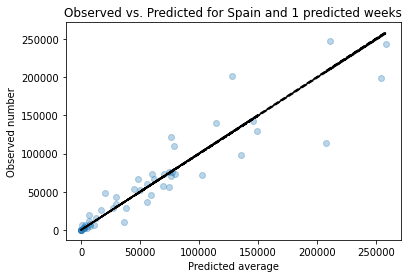

[[ 80371.]
 [ 57622.]
 [113733.]
 [ 36050.]
 [ 29656.]
 [ 44844.]
 [ 47878.]
 [ 48185.]
 [ 62093.]
 [ 63929.]
 [ 57894.]
 [ 45043.]
 [ 39237.]
 [ 33116.]
 [ 33650.]] [ 55431. 109153.  34692.  28628.  42992.  45641.  46547.  59771.  61334.
  55460.  43331.  37391.  31654.  32205.  29323.]


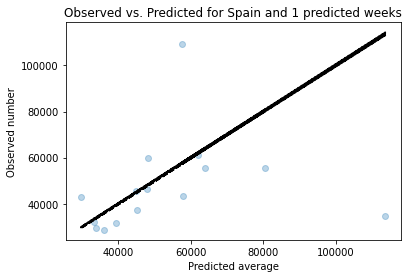

[[ 37216.]
 [ 25022.]
 [ 26042.]
 [ 53976.]
 [107398.]
 [170158.]
 [187590.]] [ 23842.  25021.  51405. 103324. 163030. 180207. 166615.]


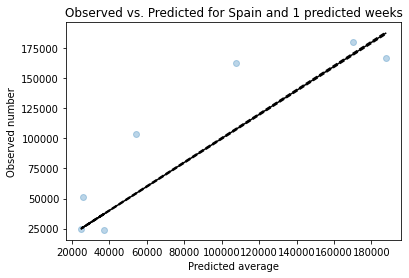

In [425]:
plot_poisson_cpd(model_p_1_w, 1, x_train_1_w, y_train_1_w)
plot_poisson_cpd(model_p_1_w, 1, x_valid_1_w, y_valid_1_w)
plot_poisson_cpd(model_p_1_w, 1, x_test_1_w, y_test_1_w)

In [426]:
shift=1  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_2_w = np.array(df_train, dtype=np.float32)
x_train_2_w = data_train_2_w[:-label_width-shift]
y_train_2_w = np.squeeze(data_train_2_w[input_width+shift:])
data_valid_2_w = np.array(df_valid, dtype=np.float32)
x_valid_2_w = data_valid_2_w[:-label_width-shift]
y_valid_2_w = np.squeeze(data_valid_2_w[input_width+shift:])
data_test_2_w = np.array(df_test, dtype=np.float32)
x_test_2_w = data_test_2_w[:-label_width-shift]
y_test_2_w = np.squeeze(data_test_2_w[input_width+shift:])

In [444]:
inputs = tf.keras.layers.Input(shape=(x_train_2_w.shape[1],))
hidden = tf.keras.layers.Dense(3, activation="relu")(inputs)
hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
# hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
rate = tf.keras.layers.Dense(1, activation=tf.math.softplus)(hidden)
p_y = tfl.DistributionLambda(tfd.Poisson)(rate)
model_p_2_w = tf.keras.models.Model(inputs=inputs, outputs=p_y)

model_p_2_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
model_p_2_w.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_179 (Dense)            (None, 3)                 6         
_________________________________________________________________
dense_180 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 4         
_________________________________________________________________
distribution_lambda_65 (Dist multiple                  0         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [445]:
result_p_2_w = model_p_2_w.fit(x_train_2_w, y_train_2_w, epochs=epochs, validation_data=(x_valid_2_w, y_valid_2_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 213ms/step - loss: 63846.1602 - val_loss: 35671.2695
Epoch 2/1000
2/2 [==============================] - 0s 16ms/step - loss: 53762.7578 - val_loss: 29285.7090
Epoch 3/1000
2/2 [==============================] - 0s 25ms/step - loss: 46833.6094 - val_loss: 24228.2051
Epoch 4/1000
2/2 [==============================] - 0s 20ms/step - loss: 40040.7266 - val_loss: 20249.3320
Epoch 5/1000
2/2 [==============================] - 0s 20ms/step - loss: 34771.5078 - val_loss: 17032.5918
Epoch 6/1000
2/2 [==============================] - 0s 20ms/step - loss: 30611.1660 - val_loss: 14405.3682
Epoch 7/1000
2/2 [==============================] - 0s 18ms/step - loss: 26485.7363 - val_loss: 11337.4893

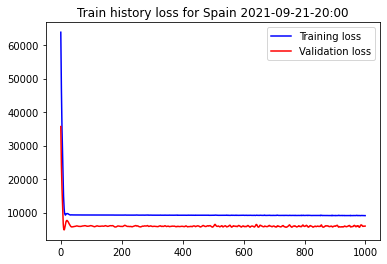

1/1 [==============================] - 0s 19ms/step - loss: 25397.3281
Poisson Distribution NLL on training set, 2 weeks forecast:  9069.2978515625
Poisson Distribution NLL on validation set, 2 weeks forecast:  5948.31005859375
Poisson Distribution NLL on test set, 2 weeks forecast:  25397.328125


In [446]:
plot_train_history(result_p_2_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path_poisson)

train_performance_2_w = model_p_2_w.evaluate(x_train_2_w, y_train_2_w, verbose=1)
val_performance_2_w = model_p_2_w.evaluate(x_valid_2_w, y_valid_2_w, verbose=1)
test_performance_2_w = model_p_2_w.evaluate(x_test_2_w, y_test_2_w, verbose=1)
print("Poisson Distribution NLL on training set, 2 weeks forecast: ", train_performance_2_w)
print("Poisson Distribution NLL on validation set, 2 weeks forecast: ", val_performance_2_w)
print("Poisson Distribution NLL on test set, 2 weeks forecast: ", test_performance_2_w)

[6.90000e+01 7.30000e+01 1.00000e+02 7.20000e+01 6.80000e+01 1.25000e+02
 5.86000e+02 6.61100e+03 2.11570e+04 5.32390e+04 5.94280e+04 4.10820e+04
 3.17350e+04 3.81040e+04 1.21180e+04 7.87900e+03 7.99700e+03 5.27900e+03
 5.30100e+03 2.43300e+03 2.66400e+03 2.78500e+03 2.82600e+03 2.45900e+03
 3.88500e+03 7.02900e+03 1.36590e+04 1.81860e+04 2.89940e+04 3.17360e+04
 4.82320e+04 5.93090e+04 6.63690e+04 7.52390e+04 8.23070e+04 8.55920e+04
 8.20630e+04 7.93550e+04 8.40990e+04 1.22141e+05 1.55903e+05 1.59912e+05
 1.45431e+05 1.09344e+05 7.95680e+04 6.28890e+04 5.11730e+04 7.41980e+04
 6.45050e+04 8.21830e+04 1.35885e+05 2.25611e+05 2.76755e+05 2.72187e+05]
(54,)
[5.30000e+01 5.70000e+01 8.10000e+01 5.60000e+01 5.20000e+01 1.04000e+02
 5.39000e+02 6.45200e+03 2.08720e+04 5.27870e+04 5.89510e+04 4.06850e+04
 3.13860e+04 3.77220e+04 1.19030e+04 7.70600e+03 7.82200e+03 5.13700e+03
 5.15900e+03 2.33700e+03 2.56300e+03 2.68200e+03 2.72200e+03 2.36200e+03
 3.76300e+03 6.86500e+03 1.34300e+04 1.79220

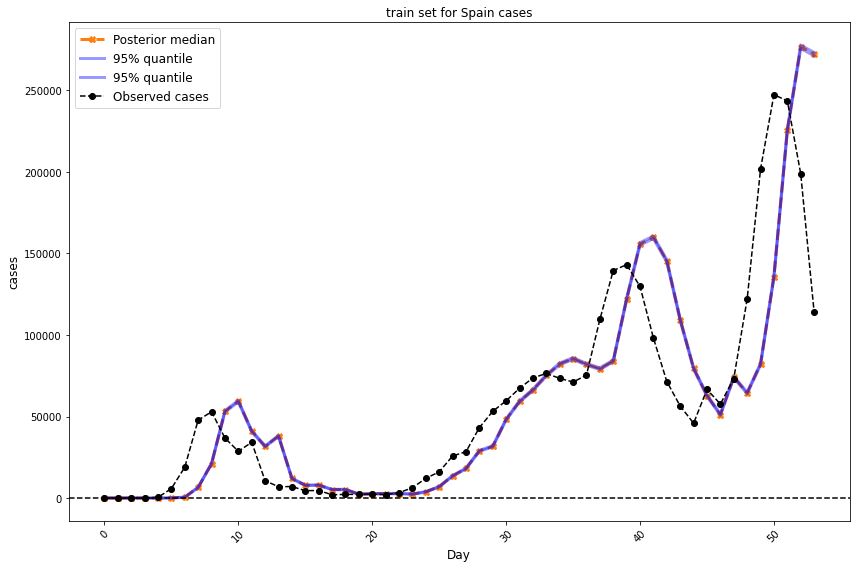

[ 86418.  61991. 122601.  38745.  31837.  48251.  51223.  52203.  67259.
  68335.  62061.  48430.  41844.  35420.]
(14,)
[ 85842.  61503. 121915.  38360.  31488.  47821.  50780.  51756.  66751.
  67823.  61573.  47999.  41444.  35052.]
[ 86995.  62479. 123288.  39131.  32187.  48682.  51667.  52651.  67768.
  68848.  62550.  48862.  42245.  35789.]


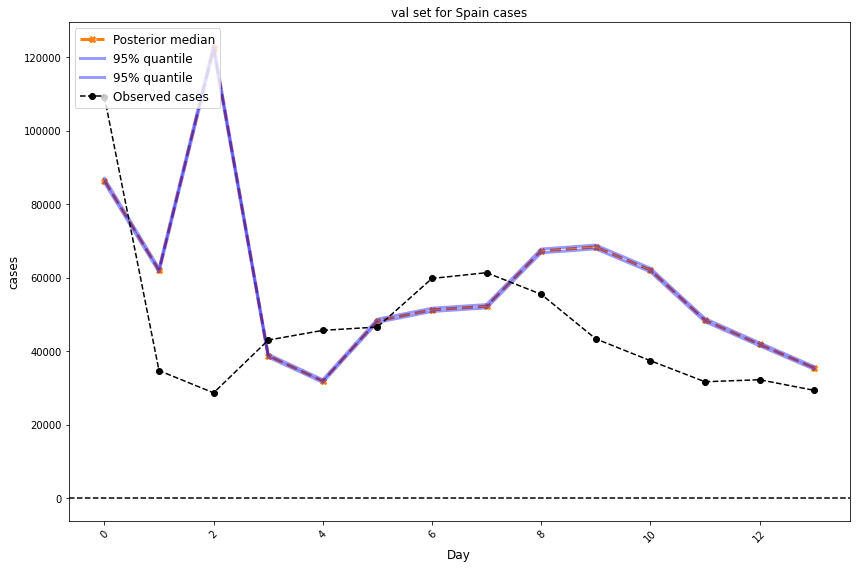

[ 40048.  26856.  27824.  57408. 115468. 181715.]
(6,)
[ 39656.  26535.  27498.  56939. 114802. 180880.]
[ 40441.  27178.  28151.  57878. 116134. 182551.]


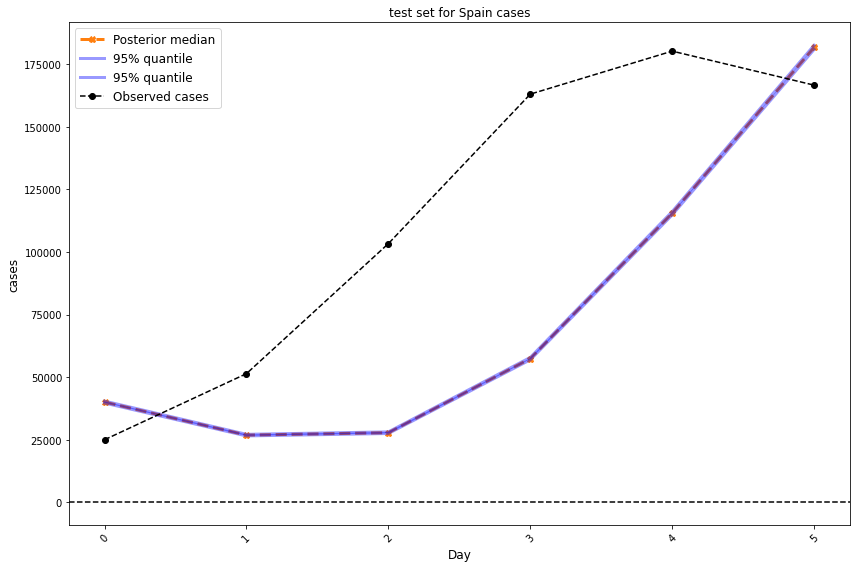

In [447]:
plot_poisson_model(model_p_2_w, plot_model="train", plot_col="cases", x=x_train_2_w, y=y_train_2_w,
                   final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_2_w, plot_model="val", plot_col="cases", x=x_valid_2_w, y=y_valid_2_w,
                   final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_2_w, plot_model="test", plot_col="cases", x=x_test_2_w, y=y_test_2_w,
                   final_image_path=graphs_path + image_path)

[[8.60000e+01]
 [7.80000e+01]
 [7.10000e+01]
 [8.20000e+01]
 [7.80000e+01]
 [1.30000e+02]
 [6.40000e+02]
 [6.69500e+03]
 [2.14870e+04]
 [5.35550e+04]
 [5.92980e+04]
 [4.12020e+04]
 [3.23140e+04]
 [3.81700e+04]
 [1.19830e+04]
 [7.94200e+03]
 [7.99400e+03]
 [5.24500e+03]
 [5.40300e+03]
 [2.34900e+03]
 [2.65500e+03]
 [2.72000e+03]
 [2.95200e+03]
 [2.44200e+03]
 [3.91700e+03]
 [7.14100e+03]
 [1.35660e+04]
 [1.80000e+04]
 [2.88800e+04]
 [3.16520e+04]
 [4.84940e+04]
 [5.95270e+04]
 [6.65030e+04]
 [7.48950e+04]
 [8.25980e+04]
 [8.45830e+04]
 [8.21810e+04]
 [7.96380e+04]
 [8.46760e+04]
 [1.21889e+05]
 [1.55754e+05]
 [1.59711e+05]
 [1.45190e+05]
 [1.09180e+05]
 [7.96570e+04]
 [6.33510e+04]
 [5.13460e+04]
 [7.43340e+04]
 [6.46800e+04]
 [8.17880e+04]
 [1.36107e+05]
 [2.25054e+05]
 [2.76488e+05]
 [2.72123e+05]] [0.00000e+00 1.00000e+00 0.00000e+00 4.30000e+01 4.55000e+02 5.89100e+03
 1.89830e+04 4.78610e+04 5.29330e+04 3.68590e+04 2.86990e+04 3.42470e+04
 1.06770e+04 6.99600e+03 7.12000e+03 4.5920

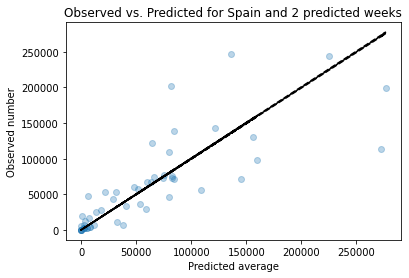

[[ 86002.]
 [ 61673.]
 [122068.]
 [ 38888.]
 [ 32098.]
 [ 47747.]
 [ 51099.]
 [ 52468.]
 [ 67121.]
 [ 68120.]
 [ 62397.]
 [ 47805.]
 [ 41836.]
 [ 35153.]] [109153.  34692.  28628.  42992.  45641.  46547.  59771.  61334.  55460.
  43331.  37391.  31654.  32205.  29323.]


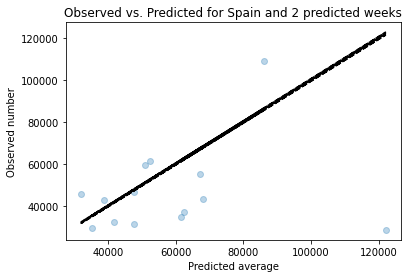

[[ 39979.]
 [ 26624.]
 [ 28237.]
 [ 57473.]
 [115723.]
 [182214.]] [ 25021.  51405. 103324. 163030. 180207. 166615.]


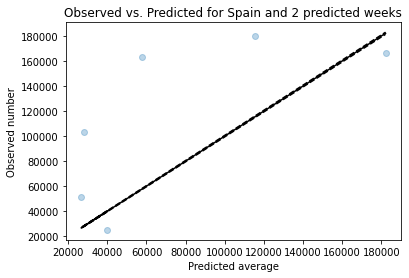

In [448]:
plot_poisson_cpd(model_p_2_w, 2, x_train_2_w, y_train_2_w)
plot_poisson_cpd(model_p_2_w, 2, x_valid_2_w, y_valid_2_w)
plot_poisson_cpd(model_p_2_w, 2, x_test_2_w, y_test_2_w)

In [449]:
shift=2  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_3_w = np.array(df_train, dtype=np.float32)
x_train_3_w = data_train_3_w[:-label_width-shift]
y_train_3_w = np.squeeze(data_train_3_w[input_width+shift:])
data_valid_3_w = np.array(df_valid, dtype=np.float32)
x_valid_3_w = data_valid_3_w[:-label_width-shift]
y_valid_3_w = np.squeeze(data_valid_3_w[input_width+shift:])
data_test_3_w = np.array(df_test, dtype=np.float32)
x_test_3_w = data_test_3_w[:-label_width-shift]
y_test_3_w = np.squeeze(data_test_3_w[input_width+shift:])

In [463]:
inputs = tf.keras.layers.Input(shape=(x_train_3_w.shape[1],))
hidden = tf.keras.layers.Dense(3, activation="relu")(inputs)
hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
# hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
rate = tf.keras.layers.Dense(1, activation=tf.math.softplus)(hidden)
p_y = tfl.DistributionLambda(tfd.Poisson)(rate)
model_p_3_w = tf.keras.models.Model(inputs=inputs, outputs=p_y)

model_p_3_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
model_p_3_w.summary()

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_197 (Dense)            (None, 3)                 6         
_________________________________________________________________
dense_198 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 4         
_________________________________________________________________
distribution_lambda_71 (Dist multiple                  0         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [464]:
result_p_3_w = model_p_3_w.fit(x_train_3_w, y_train_3_w, epochs=epochs, validation_data=(x_valid_3_w, y_valid_3_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 153ms/step - loss: 38302.3086 - val_loss: 8068.5342
Epoch 2/1000
2/2 [==============================] - 0s 16ms/step - loss: 34507.9062 - val_loss: 6766.3691
Epoch 3/1000
2/2 [==============================] - 0s 16ms/step - loss: 31584.4551 - val_loss: 5776.5791
Epoch 4/1000
2/2 [==============================] - 0s 16ms/step - loss: 28769.2871 - val_loss: 5111.4028
Epoch 5/1000
2/2 [==============================] - 0s 23ms/step - loss: 26376.1094 - val_loss: 4749.5830
Epoch 6/1000
2/2 [==============================] - 0s 16ms/step - loss: 24452.3281 - val_loss: 4669.6045
Epoch 7/1000
2/2 [==============================] - 0s 16ms/step - loss: 22856.6738 - val_loss: 4841.3096

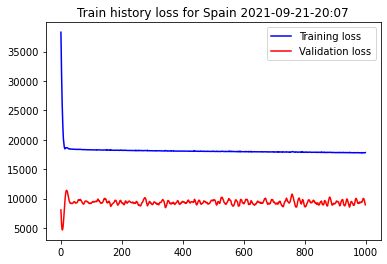

1/1 [==============================] - 0s 16ms/step - loss: 56763.4141
Poisson Distribution NLL on training set, 2 weeks forecast:  17785.376953125
Poisson Distribution NLL on validation set, 2 weeks forecast:  8942.8759765625
Poisson Distribution NLL on test set, 2 weeks forecast:  56763.4140625


In [465]:
plot_train_history(result_p_3_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path_poisson)

train_performance_3_w = model_p_3_w.evaluate(x_train_3_w, y_train_3_w, verbose=1)
val_performance_3_w = model_p_3_w.evaluate(x_valid_3_w, y_valid_3_w, verbose=1)
test_performance_3_w = model_p_3_w.evaluate(x_test_3_w, y_test_3_w, verbose=1)
print("Poisson Distribution NLL on training set, 3 weeks forecast: ", train_performance_3_w)
print("Poisson Distribution NLL on validation set, 3 weeks forecast: ", val_performance_3_w)
print("Poisson Distribution NLL on test set, 3 weeks forecast: ", test_performance_3_w)

[3.70000e+01 5.80000e+01 4.50000e+01 4.20000e+01 3.50000e+01 9.20000e+01
 5.67000e+02 7.01500e+03 2.29260e+04 5.69230e+04 6.37550e+04 4.42900e+04
 3.46530e+04 4.10600e+04 1.27740e+04 8.52200e+03 8.40900e+03 5.66000e+03
 5.57700e+03 2.55600e+03 2.74700e+03 2.77300e+03 2.99700e+03 2.55800e+03
 4.13000e+03 7.61700e+03 1.46420e+04 1.89750e+04 3.12290e+04 3.44310e+04
 5.19520e+04 6.37920e+04 7.16820e+04 8.06680e+04 8.80420e+04 9.17030e+04
 8.77020e+04 8.52480e+04 8.99130e+04 1.31187e+05 1.66744e+05 1.71398e+05
 1.54837e+05 1.17344e+05 8.53010e+04 6.74030e+04 5.51360e+04 7.99720e+04
 6.90480e+04 8.78990e+04 1.46106e+05 2.41054e+05 2.95337e+05]
(53,)
[2.60000e+01 4.40000e+01 3.20000e+01 3.00000e+01 2.40000e+01 7.40000e+01
 5.21000e+02 6.85100e+03 2.26300e+04 5.64560e+04 6.32610e+04 4.38780e+04
 3.42890e+04 4.06630e+04 1.25530e+04 8.34200e+03 8.23000e+03 5.51300e+03
 5.43100e+03 2.45700e+03 2.64500e+03 2.67000e+03 2.89000e+03 2.45900e+03
 4.00500e+03 7.44600e+03 1.44050e+04 1.87050e+04 3.08830

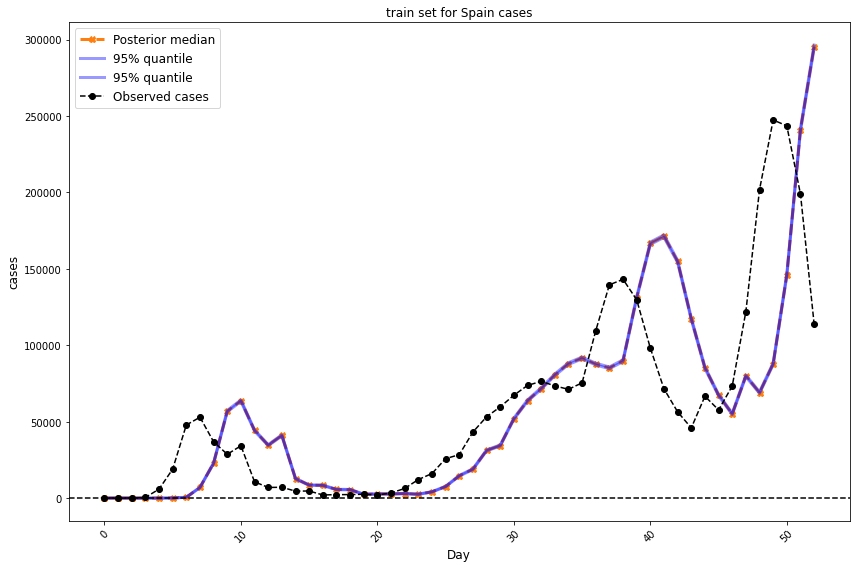

[ 92526.  66191. 130115.  41531.  34296.  51531.  54500.  56378.  71513.
  73462.  66801.  51915.  44322.]
(13,)
[ 91930.  65687. 129408.  41132.  33934.  51087.  54043.  55913.  70989.
  72931.  66295.  51469.  43910.]
[ 93123.  66696. 130822.  41931.  34659.  51976.  54958.  56844.  72038.
  73994.  67308.  52362.  44735.]


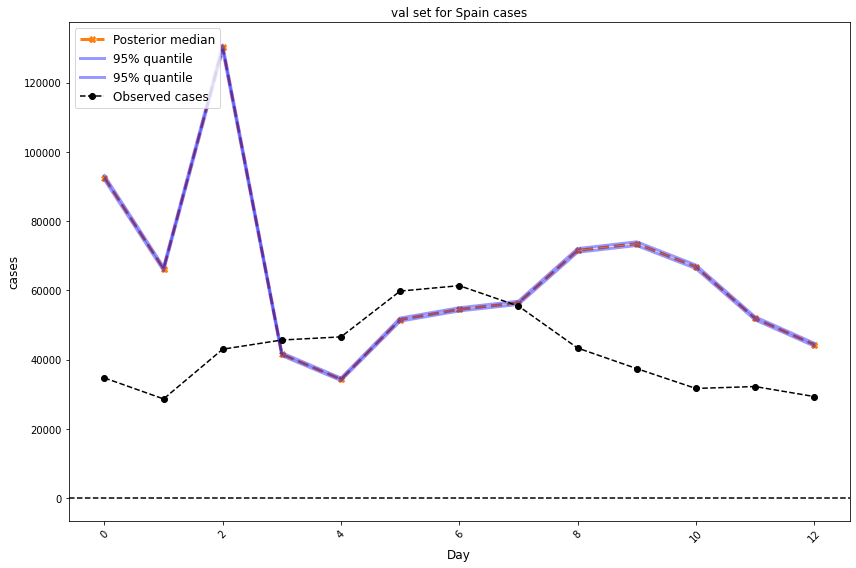

[ 42699.  28570.  29921.  61458. 123749.]
(5,)
[ 42294.  28239.  29582.  60973. 123060.]
[ 43104.  28902.  30261.  61944. 124439.]


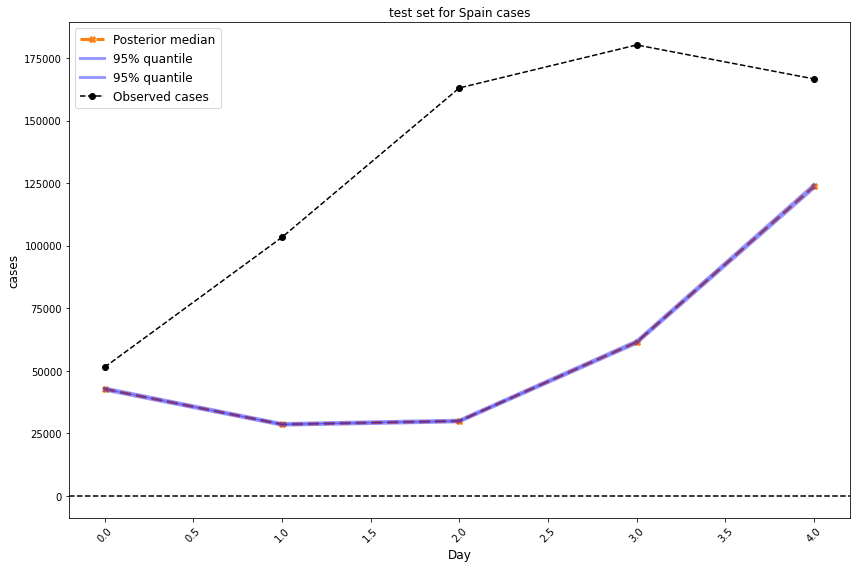

In [466]:
plot_poisson_model(model_p_3_w, plot_model="train", plot_col="cases", x=x_train_3_w, y=y_train_3_w,
                   final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_3_w, plot_model="val", plot_col="cases", x=x_valid_3_w, y=y_valid_3_w,
                   final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_3_w, plot_model="test", plot_col="cases", x=x_test_3_w, y=y_test_3_w,
                   final_image_path=graphs_path + image_path)

[[3.90000e+01]
 [5.90000e+01]
 [4.00000e+01]
 [4.20000e+01]
 [4.30000e+01]
 [9.90000e+01]
 [5.90000e+02]
 [7.22000e+03]
 [2.25850e+04]
 [5.71940e+04]
 [6.32810e+04]
 [4.44870e+04]
 [3.44190e+04]
 [4.09560e+04]
 [1.29690e+04]
 [8.36000e+03]
 [8.56500e+03]
 [5.51600e+03]
 [5.61800e+03]
 [2.51200e+03]
 [2.82900e+03]
 [2.81500e+03]
 [3.06900e+03]
 [2.53000e+03]
 [4.07100e+03]
 [7.56600e+03]
 [1.47370e+04]
 [1.90550e+04]
 [3.09350e+04]
 [3.39870e+04]
 [5.16550e+04]
 [6.34160e+04]
 [7.16300e+04]
 [7.99880e+04]
 [8.76730e+04]
 [9.20480e+04]
 [8.73340e+04]
 [8.52480e+04]
 [8.99510e+04]
 [1.31035e+05]
 [1.66883e+05]
 [1.70983e+05]
 [1.54733e+05]
 [1.17248e+05]
 [8.53540e+04]
 [6.75480e+04]
 [5.50880e+04]
 [7.97880e+04]
 [6.94790e+04]
 [8.77420e+04]
 [1.46038e+05]
 [2.41560e+05]
 [2.95684e+05]] [1.00000e+00 0.00000e+00 4.30000e+01 4.55000e+02 5.89100e+03 1.89830e+04
 4.78610e+04 5.29330e+04 3.68590e+04 2.86990e+04 3.42470e+04 1.06770e+04
 6.99600e+03 7.12000e+03 4.59200e+03 4.68200e+03 2.08200e+

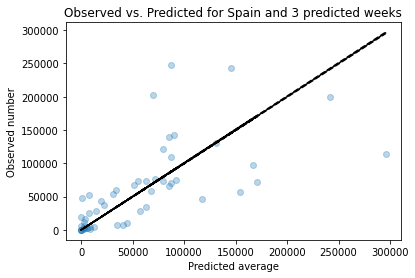

[[ 92898.]
 [ 66408.]
 [130944.]
 [ 41681.]
 [ 34237.]
 [ 51346.]
 [ 54398.]
 [ 56146.]
 [ 71853.]
 [ 73291.]
 [ 66509.]
 [ 51841.]
 [ 44630.]] [34692. 28628. 42992. 45641. 46547. 59771. 61334. 55460. 43331. 37391.
 31654. 32205. 29323.]


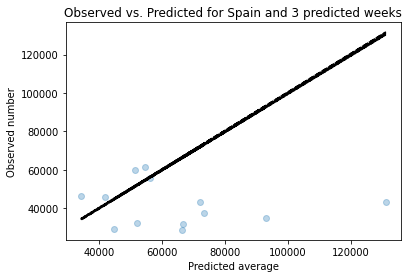

[[ 42769.]
 [ 28608.]
 [ 29985.]
 [ 61389.]
 [123264.]] [ 51405. 103324. 163030. 180207. 166615.]


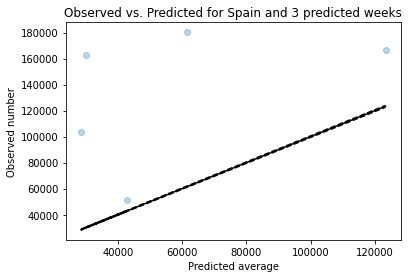

In [467]:
plot_poisson_cpd(model_p_3_w, 3, x_train_3_w, y_train_3_w)
plot_poisson_cpd(model_p_3_w, 3, x_valid_3_w, y_valid_3_w)
plot_poisson_cpd(model_p_3_w, 3, x_test_3_w, y_test_3_w)

In [468]:
shift=3  # Indica el salto entre la semana con datos y la semana a predecir: 1 indica un salto de 1 semana,
         # por lo tanto, se hará una predicción de 2 semanas después
data_train_4_w = np.array(df_train, dtype=np.float32)
x_train_4_w = data_train_4_w[:-label_width-shift]
y_train_4_w = np.squeeze(data_train_4_w[input_width+shift:])
data_valid_4_w = np.array(df_valid, dtype=np.float32)
x_valid_4_w = data_valid_4_w[:-label_width-shift]
y_valid_4_w = np.squeeze(data_valid_4_w[input_width+shift:])
data_test_4_w = np.array(df_test, dtype=np.float32)
x_test_4_w = data_test_4_w[:-label_width-shift]
y_test_4_w = np.squeeze(data_test_4_w[input_width+shift:])

In [471]:
inputs = tf.keras.layers.Input(shape=(x_train_4_w.shape[1],))
hidden = tf.keras.layers.Dense(3, activation="relu")(inputs)
hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
# hidden = tf.keras.layers.Dense(3, activation="relu")(hidden)
rate = tf.keras.layers.Dense(1, activation=tf.math.softplus)(hidden)
p_y = tfl.DistributionLambda(tfd.Poisson)(rate)
model_p_4_w = tf.keras.models.Model(inputs=inputs, outputs=p_y)

model_p_4_w.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=nll)
model_p_4_w.summary()

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_203 (Dense)            (None, 3)                 6         
_________________________________________________________________
dense_204 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_205 (Dense)            (None, 1)                 4         
_________________________________________________________________
distribution_lambda_73 (Dist multiple                  0         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [472]:
result_p_4_w = model_p_4_w.fit(x_train_4_w, y_train_4_w, epochs=epochs, validation_data=(x_valid_4_w, y_valid_4_w), verbose=True)

Epoch 1/1000
2/2 [==============================] - 1s 182ms/step - loss: 130236.4922 - val_loss: 54015.3945
Epoch 2/1000
2/2 [==============================] - 0s 20ms/step - loss: 122491.2109 - val_loss: 49106.1445
Epoch 3/1000
2/2 [==============================] - 0s 20ms/step - loss: 115689.5781 - val_loss: 44559.4883
Epoch 4/1000
2/2 [==============================] - 0s 20ms/step - loss: 108951.9453 - val_loss: 40377.3750
Epoch 5/1000
2/2 [==============================] - 0s 20ms/step - loss: 102518.3906 - val_loss: 36539.6992
Epoch 6/1000
2/2 [==============================] - 0s 18ms/step - loss: 97004.8906 - val_loss: 32997.9961
Epoch 7/1000
2/2 [==============================] - 0s 16ms/step - loss: 91854.9297 - val_loss: 29762.7480

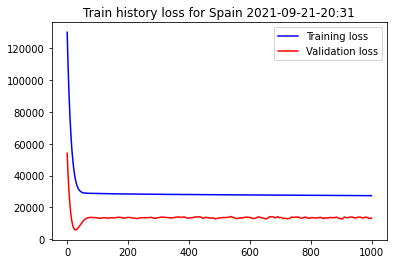

1/1 [==============================] - 0s 17ms/step - loss: 91918.4219
Poisson Distribution NLL on training set, 4 weeks forecast:  27326.451171875
Poisson Distribution NLL on validation set, 4 weeks forecast:  13143.2421875
Poisson Distribution NLL on test set, 4 weeks forecast:  91918.421875


In [473]:
plot_train_history(result_p_4_w, 'Train history loss for ' + country + " " +
                   datetime.datetime.now().strftime("%Y-%m-%d-%H:%M"), final_model_path + image_path_poisson)

train_performance_4_w = model_p_4_w.evaluate(x_train_4_w, y_train_4_w, verbose=1)
val_performance_4_w = model_p_4_w.evaluate(x_valid_4_w, y_valid_4_w, verbose=1)
test_performance_4_w = model_p_4_w.evaluate(x_test_4_w, y_test_4_w, verbose=1)
print("Poisson Distribution NLL on training set, 4 weeks forecast: ", train_performance_4_w)
print("Poisson Distribution NLL on validation set, 4 weeks forecast: ", val_performance_4_w)
print("Poisson Distribution NLL on test set, 4 weeks forecast: ", test_performance_4_w)

[2.30000e+01 3.30000e+01 3.50000e+01 2.40000e+01 2.90000e+01 7.50000e+01
 6.15000e+02 7.93900e+03 2.54840e+04 6.39540e+04 7.05630e+04 4.91650e+04
 3.84560e+04 4.55780e+04 1.41660e+04 9.35600e+03 9.40600e+03 6.13800e+03
 6.19900e+03 2.81800e+03 3.11400e+03 3.17100e+03 3.40100e+03 2.70600e+03
 4.43500e+03 8.44200e+03 1.63470e+04 2.15370e+04 3.42700e+04 3.78460e+04
 5.73400e+04 7.07110e+04 7.91290e+04 9.00030e+04 9.83290e+04 1.01342e+05
 9.70460e+04 9.46500e+04 1.00604e+05 1.45914e+05 1.85595e+05 1.90616e+05
 1.73155e+05 1.30306e+05 9.45350e+04 7.50730e+04 6.07200e+04 8.85820e+04
 7.69380e+04 9.79160e+04 1.62343e+05 2.67800e+05]
(52,)
[1.40000e+01 2.20000e+01 2.40000e+01 1.50000e+01 1.90000e+01 5.90000e+01
 5.67000e+02 7.76500e+03 2.51720e+04 6.34590e+04 7.00430e+04 4.87310e+04
 3.80720e+04 4.51600e+04 1.39330e+04 9.16700e+03 9.21600e+03 5.98500e+03
 6.04500e+03 2.71400e+03 3.00500e+03 3.06100e+03 3.28700e+03 2.60500e+03
 4.30500e+03 8.26200e+03 1.60970e+04 2.12500e+04 3.39080e+04 3.74650

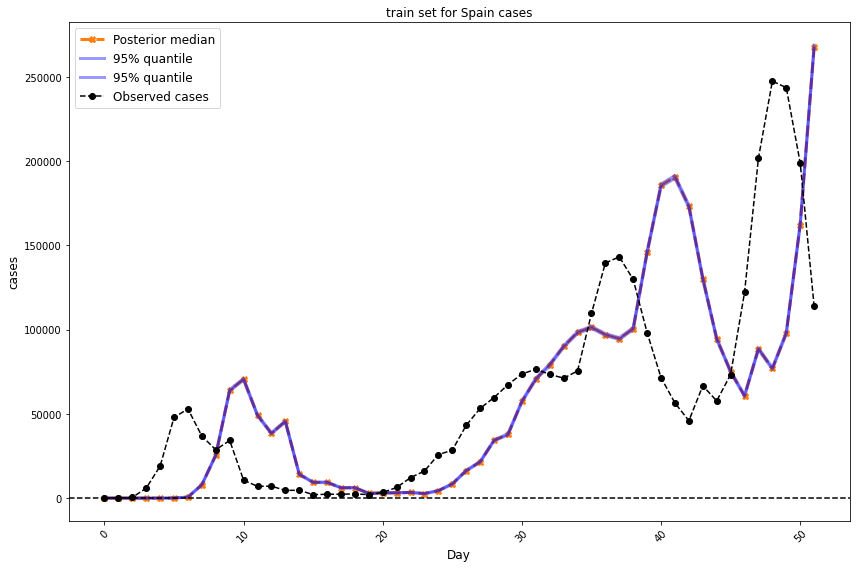

[103338.  73669. 145274.  46091.  37977.  57550.  60160.  62298.  79189.
  81556.  73842.  58059.]
(12,)
[102708.  73138. 144527.  45671.  37596.  57080.  59680.  61809.  78638.
  80997.  73310.  57587.]
[103969.  74201. 146022.  46512.  38359.  58021.  60641.  62788.  79741.
  82116.  74375.  58532.]


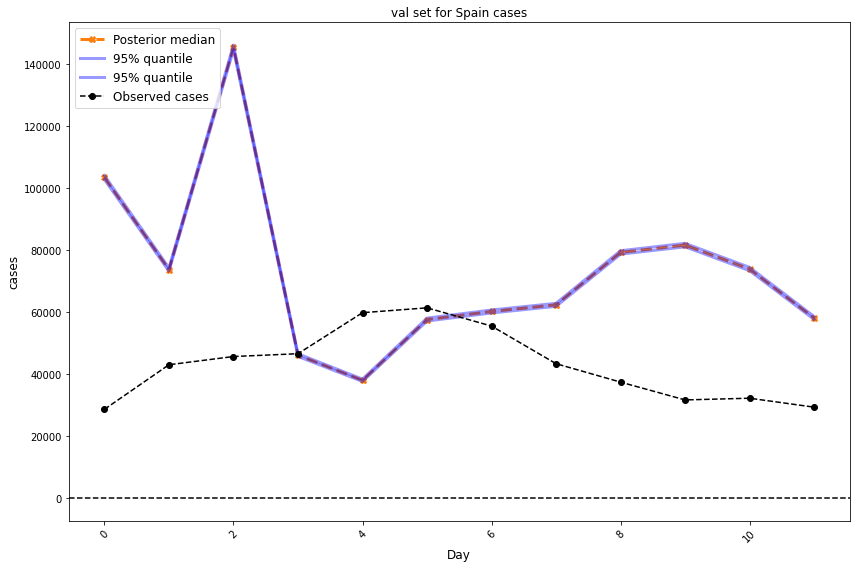

[46806. 31752. 33368. 68854.]
(4,)
[46382. 31403. 33010. 68340.]
[47231. 32102. 33726. 69369.]


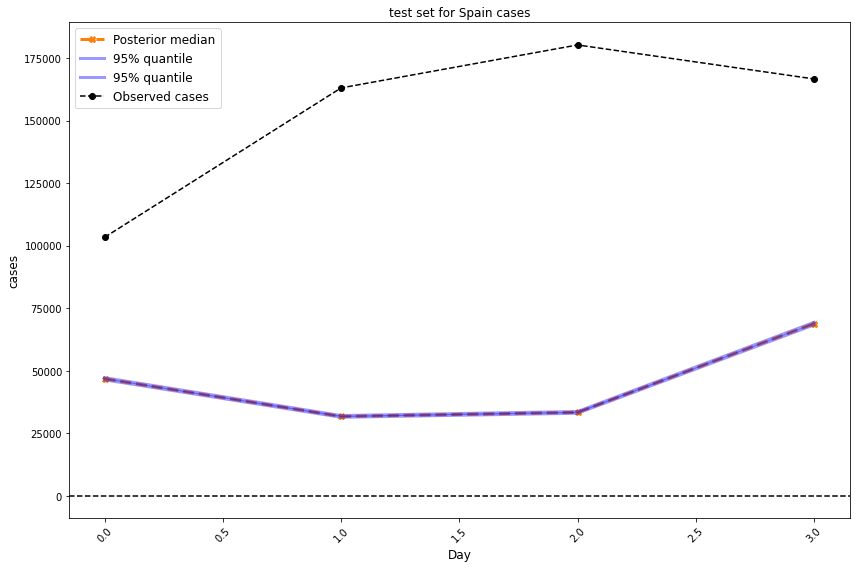

In [474]:
plot_poisson_model(model_p_4_w, plot_model="train", plot_col="cases", x=x_train_4_w, y=y_train_4_w,
                   final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_4_w, plot_model="val", plot_col="cases", x=x_valid_4_w, y=y_valid_4_w,
                   final_image_path=graphs_path + image_path)
plot_poisson_model(model_p_4_w, plot_model="test", plot_col="cases", x=x_test_4_w, y=y_test_4_w,
                   final_image_path=graphs_path + image_path)

[[2.50000e+01]
 [3.80000e+01]
 [3.10000e+01]
 [3.20000e+01]
 [2.70000e+01]
 [1.09000e+02]
 [6.19000e+02]
 [7.95000e+03]
 [2.52090e+04]
 [6.40090e+04]
 [7.05360e+04]
 [4.90560e+04]
 [3.78240e+04]
 [4.57190e+04]
 [1.42430e+04]
 [9.25000e+03]
 [9.43100e+03]
 [6.08000e+03]
 [6.23800e+03]
 [2.69800e+03]
 [3.03100e+03]
 [3.17000e+03]
 [3.32500e+03]
 [2.72200e+03]
 [4.45200e+03]
 [8.29600e+03]
 [1.63650e+04]
 [2.14190e+04]
 [3.44590e+04]
 [3.77720e+04]
 [5.72180e+04]
 [7.12510e+04]
 [7.94340e+04]
 [8.89870e+04]
 [9.80080e+04]
 [1.01941e+05]
 [9.77690e+04]
 [9.46090e+04]
 [9.99950e+04]
 [1.45881e+05]
 [1.86257e+05]
 [1.90384e+05]
 [1.72545e+05]
 [1.30116e+05]
 [9.55010e+04]
 [7.50480e+04]
 [6.12960e+04]
 [8.86810e+04]
 [7.72260e+04]
 [9.79120e+04]
 [1.62866e+05]
 [2.68241e+05]] [0.00000e+00 4.30000e+01 4.55000e+02 5.89100e+03 1.89830e+04 4.78610e+04
 5.29330e+04 3.68590e+04 2.86990e+04 3.42470e+04 1.06770e+04 6.99600e+03
 7.12000e+03 4.59200e+03 4.68200e+03 2.08200e+03 2.29500e+03 2.33300e+03


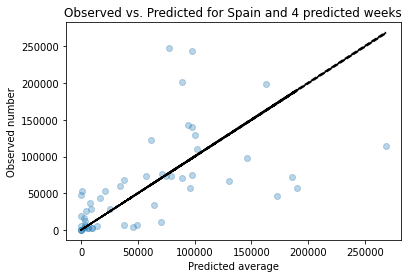

[[102169.]
 [ 73806.]
 [145191.]
 [ 46147.]
 [ 37679.]
 [ 57275.]
 [ 60618.]
 [ 61890.]
 [ 79844.]
 [ 81827.]
 [ 73878.]
 [ 57435.]] [28628. 42992. 45641. 46547. 59771. 61334. 55460. 43331. 37391. 31654.
 32205. 29323.]


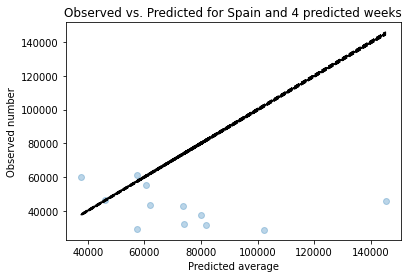

[[47530.]
 [31225.]
 [32836.]
 [68397.]] [103324. 163030. 180207. 166615.]


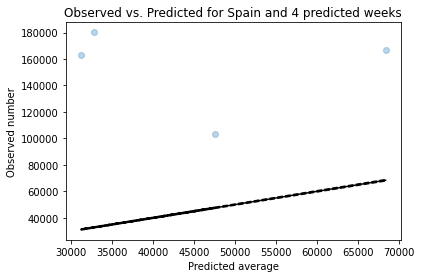

In [475]:
plot_poisson_cpd(model_p_4_w, 4, x_train_4_w, y_train_4_w)
plot_poisson_cpd(model_p_4_w, 4, x_valid_4_w, y_valid_4_w)
plot_poisson_cpd(model_p_4_w, 4, x_test_4_w, y_test_4_w)

In [476]:
print("SUMMARY:\n")
print("Linear Regression NLL on test 1 week: ", test_performance_1_w)
print("Linear Regression NLL on test 2 weeks: ", test_performance_2_w)
print("Linear Regression NLL on test 3 weeks: ", test_performance_3_w)
print("Linear Regression NLL on test 4 weeks: ", test_performance_4_w)

SUMMARY:

Linear Regression NLL on test 1 week:  6321.5224609375
Linear Regression NLL on test 2 weeks:  25397.328125
Linear Regression NLL on test 3 weeks:  56763.4140625
Linear Regression NLL on test 4 weeks:  91918.421875


## Predicción y generación de ficheros

In [519]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_p_1_w.predict(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w, quantiles, interpolation="midpoint")
y_hat_2_w = model_p_2_w.predict(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w, quantiles, interpolation="midpoint")
y_hat_3_w = model_p_3_w.predict(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w, quantiles, interpolation="midpoint")
y_hat_4_w = model_p_4_w.predict(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w, quantiles, interpolation="midpoint")

In [520]:
post_quantile_1_w

array([ 93981. ,  93981. ,  93981. ,  93981. ,  93981. , 108693.5,
       108693.5, 108693.5, 128175. , 128175. , 128175. , 146787. ,
       158474. , 158474. , 158474. , 171987.5, 171987.5, 171987.5,
       180996.5, 180996.5, 180996.5, 180996.5, 180996.5])

In [521]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-02", date_end="2021-08-07",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-02", date_end="2021-08-14",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-02", date_end="2021-08-21",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-02", date_end="2021-08-28",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")

C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-02-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-02-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-02-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-02-UNED-CovidPredPMA-Poisson.csv


In [522]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-08-07")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [523]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]

In [524]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_p_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_p_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_p_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_p_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")

In [525]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-09", date_end="2021-08-14",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-09", date_end="2021-08-21",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-09", date_end="2021-08-28",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-09", date_end="2021-09-04",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")

C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-09-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-09-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-09-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-09-UNED-CovidPredPMA-Poisson.csv


In [526]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv",
                     data_path + "truth_JHU-Incident Deaths.csv", "2021-08-14")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [527]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]


In [528]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_p_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_p_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_p_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_p_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")

In [529]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-16", date_end="2021-08-21",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-16", date_end="2021-08-28",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-16", date_end="2021-09-04",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-16", date_end="2021-09-11",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")

C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-16-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-16-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-16-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-16-UNED-CovidPredPMA-Poisson.csv


In [530]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-08-21")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [531]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]

In [532]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_p_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_p_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_p_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_p_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")


In [533]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-23", date_end="2021-08-28",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-23", date_end="2021-09-04",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-23", date_end="2021-09-11",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-23", date_end="2021-09-18",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")

C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-23-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-23-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-23-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-23-UNED-CovidPredPMA-Poisson.csv


In [534]:
df = read_truth_data(data_path + "truth_JHU-Incident Cases.csv", data_path + "truth_JHU-Incident Deaths.csv",
                     "2021-08-28")
df_test = df[-int(len(df) * (test_data_pcnt / 100)):]

C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\pmarc\PycharmProjects\covid19-forecast-hub-europe\venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 

In [535]:
shift=0
data_test = np.array(df_test, dtype=np.float32)
x_test_1_w = data_test[:-label_width-shift]
shift=1
x_test_2_w = data_test[:-label_width-shift]
shift=2
x_test_3_w = data_test[:-label_width-shift]
shift=3
x_test_4_w = data_test[:-label_width-shift]


In [536]:
# Generamos predicciones y los cuantiles para poder comparar con los modelos del Hub
y_hat_1_w = model_p_1_w(x_test_1_w)
post_quantile_1_w = np.percentile(y_hat_1_w.mean(), quantiles, interpolation="midpoint")
y_hat_2_w = model_p_2_w(x_test_2_w)
post_quantile_2_w = np.percentile(y_hat_2_w.mean(), quantiles, interpolation="midpoint")
y_hat_3_w = model_p_3_w(x_test_3_w)
post_quantile_3_w = np.percentile(y_hat_3_w.mean(), quantiles, interpolation="midpoint")
y_hat_4_w = model_p_4_w(x_test_4_w)
post_quantile_4_w = np.percentile(y_hat_4_w.mean(), quantiles, interpolation="midpoint")


In [537]:
create_forecasts_file(values=post_quantile_1_w, date_init="2021-08-30", date_end="2021-09-04",
                      num_weeks=1, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_2_w, date_init="2021-08-30", date_end="2021-09-11",
                      num_weeks=2, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_3_w, date_init="2021-08-30", date_end="2021-09-18",
                      num_weeks=3, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")
create_forecasts_file(values=post_quantile_4_w, date_init="2021-08-30", date_end="2021-09-25",
                      num_weeks=4, quantiles=quantiles, plot_col_index=0, folder_name="UNED-CovidPredPMA-Poisson",
                      team_model_name="UNED-CovidPredPMA-Poisson")


C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-30-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-30-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-30-UNED-CovidPredPMA-Poisson.csv
C:/Users/pmarc/PycharmProjects/covid19-forecast-hub-europe/data-processed/UNED-CovidPredPMA-Poisson/2021-08-30-UNED-CovidPredPMA-Poisson.csv
